# 2D Acoustic Wave Equation
---

Consider the 2d acoustic wave equation
$$
\begin{aligned}
&\frac{\partial p}{\partial t} = -c^2(x, z)\rho(x, z)\left(\frac{\partial u}{\partial x} + \frac{\partial v}{\partial z}\right) + f(x, z, t) \\
&\frac{\partial u}{\partial t} = -\frac{1}{\rho(x, z)}\frac{\partial p}{\partial x} \\
&\frac{\partial v}{\partial t} = -\frac{1}{\rho(x, z)}\frac{\partial p}{\partial z},
\end{aligned}
$$
where $p$ is Pressure, $u, v$ are the $x, z-$components of Particle Velocity, $c, \rho$ are Medium Velocity and Density.

The RHS
$$
f(x, z, t) = R(t)\times 1_{\{x = x_s, z = z_s, t\}} 
$$
is the source term, represented by a Ricker wavelet
$$
R(t) = \left(1-2(\pi f_0(t-t_0))^2\right)\exp\left(-(\pi f_0(t-t_0))^2\right),
$$
where $f_0 = 50$ is the dominant frequency, $t_0 = 0.05$ is time delay.

<p style="color:red"> We can probably use the same technique as the numerical code, i.e., $f(x, z, t) = R(t)\times N(x, z)$, where $N(x, z)$ is a Gaussian centering at $(x_s, z = z_s)$ ? </p>

In this case,
$$
N(x, z) = \exp\left(-\frac{1}{\alpha^2}\left((x-x_s)^2+(z-z_s)^2\right)\right).
$$


---

## Data

- $u$ is unknown
- $v_z$: Velocity in $z-$ direction; the $v$ variable in the equation
- $p$: Pressure
- $\rho(x, z)$: Medium density; We first assume it to be known as
$$
\rho(x, z) = \left\{
\begin{aligned}
&2000, &\quad z\in [100, 150], \\
&1000, &\quad \text{otherwise}.
\end{aligned}
\right.
$$

- All known data are collected in the spatial domain $(x, z) \in [1, 250]\times [1, 250]$, with grid size 5 (which means the spatial grids are {5, 10, ..., 250}. The temporal domain is $t\in [0, 0.25)$, with time step $dt = 0.0025$. This gives 100 time steps as recorded.

- The sources are located at $(x_s, z_s) = \{25, 50, \cdots, 225\} \times \{5\}$.

## Target
- Recover the direct problem $p, u, v$
- Recover the inverse problem $c$

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import time

import sys
sys.path.append("../../")
from Seismic_wave_inversion_PINN.tf_model_utils import *
from Seismic_wave_inversion_PINN.data_utils import *

plt.rcParams.update(plt.rcParamsDefault)
tf.keras.backend.set_floatx("float32")

%load_ext autoreload
%autoreload 2

In [2]:
def generate_model(layers):
	with tf.device("/device:gpu:0"):
		a = tf.Variable(np.ones((len(layers)-2, 1)), dtype = tf.float32)

		def atanh(a, x):
			return K.tanh(a*x)

		model = keras.models.Sequential()
		for i, l in enumerate(layers[:-2]):
			model.add(keras.layers.Dense(layers[i+1], input_shape = (layers[i], ), activation = lambda x: atanh(a[i], x)))
		model.add(keras.layers.Dense(layers[-1]))

		model.a = a
	return model

N_models = 9
direct_layers = [3, 32, 32, 32, 32, 3] # (x, z, t) -> (p, u, v)
direct_models = [generate_model(direct_layers) for i in range(N_models)]

inverse_layers = [2, 32, 32, 1] # (x, z) -> (c)
inverse_model = generate_model(inverse_layers)

In [3]:
@tf.function
def rho(x, z):
	return tf.where(tf.math.logical_and(tf.greater_equal(z, 100), tf.less_equal(z, 150)),
				   2000.0,
				   1000.0)

# source
f_0 = 50.0*np.pi
alpha = 2.0

@tf.function
def R(t, t_s):
	return (1-2*(f_0*(t-t_s))**2)*tf.exp(-(f_0*(t-t_s))**2)

@tf.function
def N(x, z, x_s, z_s):
	return tf.exp(-1.0/(alpha**2) * ((x-x_s)**2 + (z-z_s)**2))

@tf.function
def f(x, z, t, x_s, z_s, t_s):
	return R(t, t_s)*N(x, z, x_s, z_s)

In [4]:
loss_func = keras.losses.MeanSquaredError()
loss_func_2 = keras.losses.MeanSquaredError()
# def loss_func_2(x, y):
# 	return tf.sqrt(loss_func(x, y))
	

def get_residue_loss(tape, p, u, v, c, x, z, t, x_s, z_s, t_s):
	dp_dt = tape.gradient(p, t)
	dp_dx = tape.gradient(p, x)
	dp_dz = tape.gradient(p, z)
	du_dt = tape.gradient(u, t)
	du_dx = tape.gradient(u, x)
	dv_dt = tape.gradient(v, t)
	dv_dz = tape.gradient(v, z)
	eq1 = loss_func_2(dp_dt, -tf.square(c)*rho(x, z)*(du_dx+dv_dz)+f(x, z, t, x_s, z_s, t_s))
	eq2 = loss_func_2(du_dt, -1/rho(x, z)*dp_dx)
	eq3 = loss_func_2(dv_dt, -1/rho(x, z)*dp_dz)
	return eq1+eq2+eq3
	
# data: [x_c, z_c, t_c, 
#                x_d, z_d, t_d, p_d, v_d
#                x_i, z_i, t_i, p_i, u_i, v_i
#                x_s, z_s, t_s]
def step(data_sources):
	losses = []
	with tf.GradientTape(persistent = True) as tape:
		tape.watch([x for d in data_sources for x in d])
		for (data, direct_model) in zip(data_sources, direct_models):
			[x_c, z_c, t_c, x_d, z_d, t_d, p_d, v_d, x_i, z_i, t_i, p_i, u_i, v_i, x_s, z_s, t_s] = data
			out_c = direct_model(tf.concat([x_c, z_c, t_c], axis = 1))
			c_c = inverse_model(tf.concat([x_c, z_c], axis = 1))
			out_d = direct_model(tf.concat([x_d, z_d, t_d], axis = 1))
			c_d = inverse_model(tf.concat([x_d, z_d], axis = 1))
			out_i = direct_model(tf.concat([x_i, z_i, t_i], axis = 1))
			c_i = inverse_model(tf.concat([x_i, z_i], axis = 1))
			loss_c = get_residue_loss(tape, out_c[:, 0:1], out_c[:, 1:2], out_c[:, 2:3], c_c, x_c, z_c, t_c, x_s, z_s, t_s)
			loss_dr = get_residue_loss(tape, out_d[:, 0:1], out_d[:, 1:2], out_d[:, 2:3], c_d, x_d, z_d, t_d, x_s, z_s, t_s)
			loss_dv_v = loss_func_2(out_d[:, 2:3], v_d)
			loss_dv_p = loss_func_2(out_d[:, 0:1], p_d)
			
			loss_ir = get_residue_loss(tape, out_i[:, 0:1], out_i[:, 1:2], out_i[:, 2:3], c_i, x_i, z_i, t_i, x_s, z_s, t_s)
			loss_iv_p = loss_func_2(out_i[:, 0:1], p_i)
			loss_iv_u = loss_func_2(out_i[:, 1:2], u_i)
			loss_iv_v = loss_func_2(out_i[:, 2:3], v_i)
			losses.append([loss_c, loss_dr, loss_ir, loss_dv_p, loss_dv_v, loss_iv_p, loss_iv_u, loss_iv_v])
# 			tf.print(losses)
# 			tf.print("p_d", loss_func(out_d[:, 0:1], p_d))
# 			tf.print("v_d", loss_func(out_d[:, 2:3], v_d))
# 			tf.print("p_i", loss_func(out_i[:, 0:1], p_i))
# 			tf.print("u_i", loss_func(out_i[:, 1:2], u_i))
# 			tf.print("v_i", loss_func(out_i[:, 2:3], v_i))


		loss_c = sum([l[0] for l in losses])
		loss_dr = sum([l[1] for l in losses])
		loss_ir = sum([l[2] for l in losses])
		loss_dv_p = sum([l[3] for l in losses])
		loss_dv_v = sum([l[4] for l in losses])
		loss_iv_p = sum([l[5] for l in losses])
		loss_iv_u = sum([l[6] for l in losses])
		loss_iv_v = sum([l[7] for l in losses])
		loss = w_c*loss_c + w_dr*loss_dr + w_ir*loss_ir + w_dv_p*loss_dv_p + w_dv_v*loss_dv_v + \
				w_iv_p*loss_iv_p + w_iv_u*loss_iv_u + w_iv_v*loss_iv_v
	grads = tape.gradient(loss, [v for model in direct_models for v in model.trainable_variables] + \
						  inverse_model.trainable_variables + [model.a for model in direct_models])
	optimizer.apply_gradients(zip(grads, [v for model in direct_models for v in model.trainable_variables] + \
								  inverse_model.trainable_variables + [model.a for model in direct_models]))
	del tape
	return loss, loss_c, loss_dr, loss_ir, loss_dv_p, loss_dv_v, loss_iv_p, loss_iv_u, loss_iv_v

# d_s, d_i, d_c, d_d: dataset for each source


# data_sources: [d_1, ..., d_s]; dataset for each source
# d_j: [d_j_i, d_j_c, d_j_d, d_j_s]
# d_j_i: [x_i, z_i, t_i, p_i, u_i, v_i]
# d_j_c: [x_c, z_c, t_c]
# d_j_d: [x_d, z_d, t_d, p_d, v_d]
# d_j_s: [x_s, z_s, t_s]
def train(data_sources, epochs, batch_proportion = 0.1, print_every = 100, save_every = 10000, save_path = None):
	shuffled = lambda dataset: [tf.data.Dataset.from_tensor_slices(tuple(d)).shuffle(buffer_size = max(d[0].shape[0], 1), \
                                                        reshuffle_each_iteration = True).batch(max(int(batch_proportion*d[0].shape[0]), 1)) \
                                        for d in dataset]
	data_s = shuffled([d for d_s in data_sources for d in d_s[:-1]])
	source_locations = [d[-1] for d in data_sources]
	for epoch in range(1, epochs+1):
		losses = np.zeros((9,))
		for d in zip(*data_s): # d: [d_1_i, d_1_c, d_1_d, d_2_i, ...]
			data_sources = [list(d[i*3+1])+list(d[i*3+2])+list(d[i*3])+source_locations[i] for i in range(n_sources)]
			loss = step(data_sources)
			losses += np.array(loss)
		losses *= batch_proportion
		
		if epoch % print_every == 0:
			print("{}, Epoch: {}, Loss: {:.4e}, loss_c: {:.4e}, loss_dr: {:.4e}, loss_ir: {:.4e}, loss_dv_p: {:.4e}, loss_dv_v: {:.4e}, loss_iv_p: {:.4e}, loss_iv_u: {:.4e}, loss_iv_v: {:.4e}".format(get_time(), epoch, *list(losses)))

		if epoch % save_every == 0:
			for i, model in enumerate(direct_models):
				model.save("models/0623_9_direct_models/{}/direct_model_{}/".format(save_path, i))
			inverse_model.save("models/0623_9_direct_models/{}/inverse_model".format(save_path))

In [5]:
from scipy.io import loadmat

x_s = np.linspace(25.0, 225.0, 9)
z_s = 5.0
t_s = 0.05
n_sources = len(x_s)

domain = [0, 250]
T_max = 0.25
dx = 5
dt = 0.0025

x_d = np.linspace(5.0, 250.0, 50)
z_d = [5.0]
t_d = np.linspace(0.0, 0.2475, 100)

n_c = 1000
x_c = transform(np.random.random((n_c, 1)), *domain)
z_c = transform(np.random.random((n_c, 1)), *domain)
t_c = transform(np.random.random((n_c, 1)), 0, T_max)

n_s = 1000
x_c_source = np.vstack([transform(np.random.random((n_s, 1)), xi-5, xi+5) for xi in x_s])
z_c_source = np.vstack([transform(np.random.random((n_s, 1)), z_s-5, z_s+5) for i in x_s])
t_c_source = np.vstack([transform(np.random.random((n_s, 1)), t_s-0.05, t_s+0.05) for i in x_s])

x_c = np.vstack([x_c, x_c_source])
z_c = np.vstack([z_c, z_c_source])
t_c = np.vstack([t_c, t_c_source])

n_i = 1000
x_i = transform(np.random.random((n_i, 1)), *domain)
z_i = transform(np.random.random((n_i, 1)), *domain)
t_i = np.zeros_like(x_i)
p_i = np.zeros_like(x_i)
u_i = np.zeros_like(x_i)
v_i = np.zeros_like(x_i)

# txz_c = tensor_grid([t_c, x_c, z_c])
txz_d = tensor_grid([t_d, x_d, z_d])

map_to_tf_float32 = lambda x: list(map(lambda y: tf.constant(y, dtype = tf.float32), x))

data_sources = []
for x in x_s:
	p = loadmat("data/sr_p_{}.mat".format(int(x/5)))["sr"].reshape((-1, 1))
	v = loadmat("data/sr_vz_{}.mat".format(int(x/5)))["sr"].reshape((-1, 1))
	d_i = map_to_tf_float32([x_i, z_i, t_i, p_i, u_i, v_i])
# 	d_c = map_to_tf_float32([txz_c[:, 1:2], txz_c[:, 2:3], txz_c[:, 0:1]])
	d_c = map_to_tf_float32([x_c, z_c, t_c])
	d_d = map_to_tf_float32([txz_d[:, 1:2], txz_d[:, 2:3], txz_d[:, 0:1], p, v])
	d_s = map_to_tf_float32([x, z_s, t_s])
	data_sources.append([d_i, d_c, d_d, d_s])

In [6]:
i = 1
optimizer = keras.optimizers.Adam(lr = 1e-4)
w_c, w_dr, w_ir, w_dv_p, w_dv_v, w_iv_p, w_iv_u, w_iv_v = 1.0, 1.0, 1.0, 1e3, 1e7, 1.0, 1.0, 1.0
train(data_sources, 10000, batch_proportion = 1.0, print_every = 10, save_every = 1000, save_path = "{}_adam".format(i))

2020/06/25, 08:42:07, Epoch: 10, Loss: 2.8094e+07, loss_c: 4.7578e+03, loss_dr: 1.8243e+04, loss_ir: 1.1214e+04, loss_dv_p: 1.1552e+00, loss_dv_v: 2.8058e+00, loss_iv_p: 1.7812e+00, loss_iv_u: 2.5333e+00, loss_iv_v: 2.8513e+00
2020/06/25, 08:42:38, Epoch: 20, Loss: 1.3474e+07, loss_c: 2.3831e+03, loss_dr: 9.3214e+03, loss_ir: 6.4231e+03, loss_dv_p: 1.0132e+00, loss_dv_v: 1.3455e+00, loss_iv_p: 1.7323e+00, loss_iv_u: 2.4464e+00, loss_iv_v: 1.9909e+00
2020/06/25, 08:43:09, Epoch: 30, Loss: 5.4730e+06, loss_c: 1.2926e+03, loss_dr: 5.1929e+03, loss_ir: 4.0443e+03, loss_dv_p: 9.1243e-01, loss_dv_v: 5.4615e-01, loss_iv_p: 1.6928e+00, loss_iv_u: 2.3986e+00, loss_iv_v: 1.4652e+00
2020/06/25, 08:43:40, Epoch: 40, Loss: 2.1591e+06, loss_c: 7.8654e+02, loss_dr: 3.1493e+03, loss_ir: 2.7670e+03, loss_dv_p: 8.3725e-01, loss_dv_v: 2.1515e-01, loss_iv_p: 1.6788e+00, loss_iv_u: 2.3682e+00, loss_iv_v: 1.1839e+00
2020/06/25, 08:44:11, Epoch: 50, Loss: 1.1292e+06, loss_c: 5.1842e+02, loss_dr: 2.0398e+03, 

2020/06/25, 08:54:32, Epoch: 250, Loss: 1.3375e+05, loss_c: 2.2311e+01, loss_dr: 6.9820e+01, loss_ir: 1.2437e+02, loss_dv_p: 3.7112e-01, loss_dv_v: 1.3316e-02, loss_iv_p: 1.4834e+00, loss_iv_u: 2.1664e+00, loss_iv_v: 5.3668e-01
2020/06/25, 08:55:03, Epoch: 260, Loss: 1.2286e+05, loss_c: 2.0434e+01, loss_dr: 6.3517e+01, loss_ir: 1.1496e+02, loss_dv_p: 3.6053e-01, loss_dv_v: 1.2229e-02, loss_iv_p: 1.4741e+00, loss_iv_u: 2.1582e+00, loss_iv_v: 5.2683e-01
2020/06/25, 08:55:34, Epoch: 270, Loss: 1.1284e+05, loss_c: 1.8794e+01, loss_dr: 5.7979e+01, loss_ir: 1.0700e+02, loss_dv_p: 3.5038e-01, loss_dv_v: 1.1231e-02, loss_iv_p: 1.4647e+00, loss_iv_u: 2.1499e+00, loss_iv_v: 5.1746e-01
2020/06/25, 08:56:05, Epoch: 280, Loss: 1.0364e+05, loss_c: 1.7327e+01, loss_dr: 5.3090e+01, loss_ir: 9.9997e+01, loss_dv_p: 3.4063e-01, loss_dv_v: 1.0312e-02, loss_iv_p: 1.4552e+00, loss_iv_u: 2.1417e+00, loss_iv_v: 5.0851e-01
2020/06/25, 08:56:36, Epoch: 290, Loss: 9.5180e+04, loss_c: 1.5975e+01, loss_dr: 4.8758e

2020/06/25, 09:13:10, Epoch: 610, Loss: 9.5242e+03, loss_c: 2.5511e+00, loss_dr: 8.5839e+00, loss_ir: 1.9010e+01, loss_dv_p: 1.4890e-01, loss_dv_v: 9.3417e-04, loss_iv_p: 1.1446e+00, loss_iv_u: 1.9185e+00, loss_iv_v: 4.0151e-01
2020/06/25, 09:13:41, Epoch: 620, Loss: 9.1060e+03, loss_c: 2.4690e+00, loss_dr: 8.2838e+00, loss_ir: 1.8607e+01, loss_dv_p: 1.4551e-01, loss_dv_v: 8.9276e-04, loss_iv_p: 1.1372e+00, loss_iv_u: 1.9126e+00, loss_iv_v: 4.0094e-01
2020/06/25, 09:14:11, Epoch: 630, Loss: 8.7199e+03, loss_c: 2.3923e+00, loss_dr: 8.0005e+00, loss_ir: 1.8228e+01, loss_dv_p: 1.4221e-01, loss_dv_v: 8.5457e-04, loss_iv_p: 1.1301e+00, loss_iv_u: 1.9066e+00, loss_iv_v: 4.0041e-01
2020/06/25, 09:14:42, Epoch: 640, Loss: 8.3627e+03, loss_c: 2.3194e+00, loss_dr: 7.7324e+00, loss_ir: 1.7854e+01, loss_dv_p: 1.3900e-01, loss_dv_v: 8.1924e-04, loss_iv_p: 1.1230e+00, loss_iv_u: 1.9007e+00, loss_iv_v: 3.9990e-01
2020/06/25, 09:15:13, Epoch: 650, Loss: 8.0313e+03, loss_c: 2.2475e+00, loss_dr: 7.4783e

2020/06/25, 09:31:45, Epoch: 970, Loss: 3.2192e+03, loss_c: 1.0208e+00, loss_dr: 3.2123e+00, loss_ir: 8.5893e+00, loss_dv_p: 7.0399e-02, loss_dv_v: 3.1329e-04, loss_iv_p: 9.2914e-01, loss_iv_u: 1.7514e+00, loss_iv_v: 3.8039e-01
2020/06/25, 09:32:16, Epoch: 980, Loss: 3.1492e+03, loss_c: 9.8900e-01, loss_dr: 3.1419e+00, loss_ir: 8.3462e+00, loss_dv_p: 6.9142e-02, loss_dv_v: 3.0645e-04, loss_iv_p: 9.2400e-01, loss_iv_u: 1.7476e+00, loss_iv_v: 3.7983e-01
2020/06/25, 09:32:47, Epoch: 990, Loss: 3.0816e+03, loss_c: 9.5731e-01, loss_dr: 3.0734e+00, loss_ir: 8.1106e+00, loss_dv_p: 6.7918e-02, loss_dv_v: 2.9985e-04, loss_iv_p: 9.1894e-01, loss_iv_u: 1.7438e+00, loss_iv_v: 3.7928e-01
2020/06/25, 09:33:18, Epoch: 1000, Loss: 3.0163e+03, loss_c: 9.2596e-01, loss_dr: 3.0067e+00, loss_ir: 7.8828e+00, loss_dv_p: 6.6726e-02, loss_dv_v: 2.9348e-04, loss_iv_p: 9.1394e-01, loss_iv_u: 1.7401e+00, loss_iv_v: 3.7875e-01
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:t

2020/06/25, 09:49:25, Epoch: 1310, Loss: 1.7294e+03, loss_c: 4.1604e-01, loss_dr: 1.6378e+00, loss_ir: 3.9615e+00, loss_dv_p: 4.1598e-02, loss_dv_v: 1.6790e-04, loss_iv_p: 7.8847e-01, loss_iv_u: 1.6314e+00, loss_iv_v: 3.6939e-01
2020/06/25, 09:49:56, Epoch: 1320, Loss: 1.7032e+03, loss_c: 4.0926e-01, loss_dr: 1.6104e+00, loss_ir: 3.8902e+00, loss_dv_p: 4.1058e-02, loss_dv_v: 1.6534e-04, loss_iv_p: 7.8516e-01, loss_iv_u: 1.6281e+00, loss_iv_v: 3.6921e-01
2020/06/25, 09:50:27, Epoch: 1330, Loss: 1.6775e+03, loss_c: 4.0272e-01, loss_dr: 1.5837e+00, loss_ir: 3.8217e+00, loss_dv_p: 4.0529e-02, loss_dv_v: 1.6284e-04, loss_iv_p: 7.8187e-01, loss_iv_u: 1.6248e+00, loss_iv_v: 3.6903e-01
2020/06/25, 09:50:58, Epoch: 1340, Loss: 1.6525e+03, loss_c: 3.9639e-01, loss_dr: 1.5577e+00, loss_ir: 3.7554e+00, loss_dv_p: 4.0011e-02, loss_dv_v: 1.6040e-04, loss_iv_p: 7.7861e-01, loss_iv_u: 1.6215e+00, loss_iv_v: 3.6885e-01
2020/06/25, 09:51:30, Epoch: 1350, Loss: 1.6280e+03, loss_c: 3.9028e-01, loss_dr: 1.

2020/06/25, 10:08:03, Epoch: 1670, Loss: 1.0596e+03, loss_c: 2.5639e-01, loss_dr: 9.7929e-01, loss_ir: 2.1284e+00, loss_dv_p: 2.7519e-02, loss_dv_v: 1.0261e-04, loss_iv_p: 6.8708e-01, loss_iv_u: 1.5220e+00, loss_iv_v: 3.6344e-01
2020/06/25, 10:08:34, Epoch: 1680, Loss: 1.0467e+03, loss_c: 2.5248e-01, loss_dr: 9.6770e-01, loss_ir: 2.0972e+00, loss_dv_p: 2.7240e-02, loss_dv_v: 1.0136e-04, loss_iv_p: 6.8469e-01, loss_iv_u: 1.5193e+00, loss_iv_v: 3.6329e-01
2020/06/25, 10:09:05, Epoch: 1690, Loss: 1.0340e+03, loss_c: 2.4858e-01, loss_dr: 9.5635e-01, loss_ir: 2.0667e+00, loss_dv_p: 2.6966e-02, loss_dv_v: 1.0012e-04, loss_iv_p: 6.8233e-01, loss_iv_u: 1.5165e+00, loss_iv_v: 3.6314e-01
2020/06/25, 10:09:36, Epoch: 1700, Loss: 1.0216e+03, loss_c: 2.4472e-01, loss_dr: 9.4523e-01, loss_ir: 2.0368e+00, loss_dv_p: 2.6696e-02, loss_dv_v: 9.8910e-05, loss_iv_p: 6.7998e-01, loss_iv_u: 1.5138e+00, loss_iv_v: 3.6300e-01
2020/06/25, 10:10:07, Epoch: 1710, Loss: 1.0093e+03, loss_c: 2.4089e-01, loss_dr: 9.

INFO:tensorflow:Assets written to: models/0623_9_direct_models/1_adam/direct_model_5/assets
2020/06/25, 10:27:17, Epoch: 2040, Loss: 7.0244e+02, loss_c: 1.5792e-01, loss_dr: 6.6777e-01, loss_ir: 1.3281e+00, loss_dv_p: 1.9422e-02, loss_dv_v: 6.7848e-05, loss_iv_p: 6.0930e-01, loss_iv_u: 1.4263e+00, loss_iv_v: 3.5863e-01
2020/06/25, 10:27:48, Epoch: 2050, Loss: 6.9555e+02, loss_c: 1.5647e-01, loss_dr: 6.6174e-01, loss_ir: 1.3142e+00, loss_dv_p: 1.9251e-02, loss_dv_v: 6.7178e-05, loss_iv_p: 6.0745e-01, loss_iv_u: 1.4239e+00, loss_iv_v: 3.5851e-01
2020/06/25, 10:28:19, Epoch: 2060, Loss: 6.8878e+02, loss_c: 1.5507e-01, loss_dr: 6.5580e-01, loss_ir: 1.3007e+00, loss_dv_p: 1.9083e-02, loss_dv_v: 6.6520e-05, loss_iv_p: 6.0561e-01, loss_iv_u: 1.4215e+00, loss_iv_v: 3.5839e-01
2020/06/25, 10:28:50, Epoch: 2070, Loss: 6.8211e+02, loss_c: 1.5370e-01, loss_dr: 6.4995e-01, loss_ir: 1.2874e+00, loss_dv_p: 1.8917e-02, loss_dv_v: 6.5872e-05, loss_iv_p: 6.0378e-01, loss_iv_u: 1.4191e+00, loss_iv_v: 3.5

2020/06/25, 10:45:55, Epoch: 2400, Loss: 5.1301e+02, loss_c: 1.2499e-01, loss_dr: 4.9620e-01, loss_ir: 9.7507e-01, loss_dv_p: 1.4323e-02, loss_dv_v: 4.9484e-05, loss_iv_p: 5.4762e-01, loss_iv_u: 1.3446e+00, loss_iv_v: 3.5452e-01
2020/06/25, 10:46:26, Epoch: 2410, Loss: 5.0909e+02, loss_c: 1.2449e-01, loss_dr: 4.9255e-01, loss_ir: 9.6844e-01, loss_dv_p: 1.4206e-02, loss_dv_v: 4.9106e-05, loss_iv_p: 5.4602e-01, loss_iv_u: 1.3425e+00, loss_iv_v: 3.5441e-01
2020/06/25, 10:46:57, Epoch: 2420, Loss: 5.0523e+02, loss_c: 1.2400e-01, loss_dr: 4.8894e-01, loss_ir: 9.6192e-01, loss_dv_p: 1.4091e-02, loss_dv_v: 4.8733e-05, loss_iv_p: 5.4442e-01, loss_iv_u: 1.3404e+00, loss_iv_v: 3.5430e-01
2020/06/25, 10:47:28, Epoch: 2430, Loss: 5.0142e+02, loss_c: 1.2353e-01, loss_dr: 4.8539e-01, loss_ir: 9.5553e-01, loss_dv_p: 1.3977e-02, loss_dv_v: 4.8365e-05, loss_iv_p: 5.4283e-01, loss_iv_u: 1.3383e+00, loss_iv_v: 3.5420e-01
2020/06/25, 10:47:59, Epoch: 2440, Loss: 4.9767e+02, loss_c: 1.2307e-01, loss_dr: 4.

2020/06/25, 11:04:32, Epoch: 2760, Loss: 3.9884e+02, loss_c: 1.1262e-01, loss_dr: 3.9092e-01, loss_ir: 7.9584e-01, loss_dv_p: 1.0741e-02, loss_dv_v: 3.8468e-05, loss_iv_p: 4.9387e-01, loss_iv_u: 1.2719e+00, loss_iv_v: 3.5105e-01
2020/06/25, 11:05:03, Epoch: 2770, Loss: 3.9627e+02, loss_c: 1.1234e-01, loss_dr: 3.8865e-01, loss_ir: 7.9166e-01, loss_dv_p: 1.0656e-02, loss_dv_v: 3.8221e-05, loss_iv_p: 4.9247e-01, loss_iv_u: 1.2700e+00, loss_iv_v: 3.5096e-01
2020/06/25, 11:05:35, Epoch: 2780, Loss: 3.9372e+02, loss_c: 1.1207e-01, loss_dr: 3.8639e-01, loss_ir: 7.8753e-01, loss_dv_p: 1.0573e-02, loss_dv_v: 3.7975e-05, loss_iv_p: 4.9108e-01, loss_iv_u: 1.2681e+00, loss_iv_v: 3.5087e-01
2020/06/25, 11:06:06, Epoch: 2790, Loss: 3.9120e+02, loss_c: 1.1180e-01, loss_dr: 3.8417e-01, loss_ir: 7.8346e-01, loss_dv_p: 1.0490e-02, loss_dv_v: 3.7732e-05, loss_iv_p: 4.8968e-01, loss_iv_u: 1.2662e+00, loss_iv_v: 3.5078e-01
2020/06/25, 11:06:37, Epoch: 2800, Loss: 3.8870e+02, loss_c: 1.1154e-01, loss_dr: 3.

2020/06/25, 11:22:12, Epoch: 3100, Loss: 3.2258e+02, loss_c: 1.0573e-01, loss_dr: 3.2686e-01, loss_ir: 6.7776e-01, loss_dv_p: 8.2232e-03, loss_dv_v: 3.1124e-05, loss_iv_p: 4.4708e-01, loss_iv_u: 1.2090e+00, loss_iv_v: 3.4780e-01
2020/06/25, 11:22:43, Epoch: 3110, Loss: 3.2062e+02, loss_c: 1.0550e-01, loss_dr: 3.2532e-01, loss_ir: 6.7422e-01, loss_dv_p: 8.1585e-03, loss_dv_v: 3.0935e-05, loss_iv_p: 4.4570e-01, loss_iv_u: 1.2072e+00, loss_iv_v: 3.4769e-01
2020/06/25, 11:23:14, Epoch: 3120, Loss: 3.1867e+02, loss_c: 1.0528e-01, loss_dr: 3.2380e-01, loss_ir: 6.7067e-01, loss_dv_p: 8.0943e-03, loss_dv_v: 3.0748e-05, loss_iv_p: 4.4432e-01, loss_iv_u: 1.2054e+00, loss_iv_v: 3.4759e-01
2020/06/25, 11:23:45, Epoch: 3130, Loss: 3.1674e+02, loss_c: 1.0506e-01, loss_dr: 3.2230e-01, loss_ir: 6.6713e-01, loss_dv_p: 8.0306e-03, loss_dv_v: 3.0562e-05, loss_iv_p: 4.4294e-01, loss_iv_u: 1.2037e+00, loss_iv_v: 3.4748e-01
2020/06/25, 11:24:16, Epoch: 3140, Loss: 3.1482e+02, loss_c: 1.0484e-01, loss_dr: 3.

2020/06/25, 11:43:24, Epoch: 3510, Loss: 2.5156e+02, loss_c: 9.9164e-02, loss_dr: 2.7447e-01, loss_ir: 5.7193e-01, loss_dv_p: 5.9070e-03, loss_dv_v: 2.4283e-05, loss_iv_p: 3.9073e-01, loss_iv_u: 1.1412e+00, loss_iv_v: 3.4304e-01
2020/06/25, 11:43:55, Epoch: 3520, Loss: 2.5003e+02, loss_c: 9.8982e-02, loss_dr: 2.7341e-01, loss_ir: 5.6966e-01, loss_dv_p: 5.8580e-03, loss_dv_v: 2.4136e-05, loss_iv_p: 3.8940e-01, loss_iv_u: 1.1397e+00, loss_iv_v: 3.4292e-01
2020/06/25, 11:44:26, Epoch: 3530, Loss: 2.4851e+02, loss_c: 9.8802e-02, loss_dr: 2.7236e-01, loss_ir: 5.6740e-01, loss_dv_p: 5.8093e-03, loss_dv_v: 2.3990e-05, loss_iv_p: 3.8807e-01, loss_iv_u: 1.1381e+00, loss_iv_v: 3.4279e-01
2020/06/25, 11:44:57, Epoch: 3540, Loss: 2.4700e+02, loss_c: 9.8624e-02, loss_dr: 2.7132e-01, loss_ir: 5.6514e-01, loss_dv_p: 5.7610e-03, loss_dv_v: 2.3844e-05, loss_iv_p: 3.8674e-01, loss_iv_u: 1.1365e+00, loss_iv_v: 3.4266e-01
2020/06/25, 11:45:28, Epoch: 3550, Loss: 2.4550e+02, loss_c: 9.8448e-02, loss_dr: 2.

2020/06/25, 12:02:02, Epoch: 3870, Loss: 2.0160e+02, loss_c: 9.4518e-02, loss_dr: 2.4104e-01, loss_ir: 5.1626e-01, loss_dv_p: 4.3306e-03, loss_dv_v: 1.9464e-05, loss_iv_p: 3.4453e-01, loss_iv_u: 1.0869e+00, loss_iv_v: 3.3812e-01
2020/06/25, 12:02:33, Epoch: 3880, Loss: 2.0034e+02, loss_c: 9.4410e-02, loss_dr: 2.4022e-01, loss_ir: 5.1522e-01, loss_dv_p: 4.2919e-03, loss_dv_v: 1.9344e-05, loss_iv_p: 3.4330e-01, loss_iv_u: 1.0855e+00, loss_iv_v: 3.3798e-01
2020/06/25, 12:03:04, Epoch: 3890, Loss: 1.9910e+02, loss_c: 9.4303e-02, loss_dr: 2.3941e-01, loss_ir: 5.1418e-01, loss_dv_p: 4.2536e-03, loss_dv_v: 1.9223e-05, loss_iv_p: 3.4207e-01, loss_iv_u: 1.0841e+00, loss_iv_v: 3.3784e-01
2020/06/25, 12:03:35, Epoch: 3900, Loss: 1.9786e+02, loss_c: 9.4194e-02, loss_dr: 2.3861e-01, loss_ir: 5.1315e-01, loss_dv_p: 4.2154e-03, loss_dv_v: 1.9104e-05, loss_iv_p: 3.4085e-01, loss_iv_u: 1.0827e+00, loss_iv_v: 3.3770e-01
2020/06/25, 12:04:06, Epoch: 3910, Loss: 1.9663e+02, loss_c: 9.4083e-02, loss_dr: 2.

2020/06/25, 12:18:41, Epoch: 4190, Loss: 1.6464e+02, loss_c: 8.9282e-02, loss_dr: 2.1742e-01, loss_ir: 4.7954e-01, loss_dv_p: 3.2192e-03, loss_dv_v: 1.5894e-05, loss_iv_p: 3.0656e-01, loss_iv_u: 1.0467e+00, loss_iv_v: 3.3369e-01
2020/06/25, 12:19:12, Epoch: 4200, Loss: 1.6358e+02, loss_c: 8.9019e-02, loss_dr: 2.1676e-01, loss_ir: 4.7813e-01, loss_dv_p: 3.1885e-03, loss_dv_v: 1.5792e-05, loss_iv_p: 3.0541e-01, loss_iv_u: 1.0456e+00, loss_iv_v: 3.3355e-01
2020/06/25, 12:19:43, Epoch: 4210, Loss: 1.6253e+02, loss_c: 8.8754e-02, loss_dr: 2.1611e-01, loss_ir: 4.7672e-01, loss_dv_p: 3.1580e-03, loss_dv_v: 1.5690e-05, loss_iv_p: 3.0427e-01, loss_iv_u: 1.0446e+00, loss_iv_v: 3.3342e-01
2020/06/25, 12:20:14, Epoch: 4220, Loss: 1.6148e+02, loss_c: 8.8488e-02, loss_dr: 2.1546e-01, loss_ir: 4.7534e-01, loss_dv_p: 3.1278e-03, loss_dv_v: 1.5589e-05, loss_iv_p: 3.0312e-01, loss_iv_u: 1.0436e+00, loss_iv_v: 3.3329e-01
2020/06/25, 12:20:45, Epoch: 4230, Loss: 1.6044e+02, loss_c: 8.8222e-02, loss_dr: 2.

2020/06/25, 12:37:20, Epoch: 4550, Loss: 1.2986e+02, loss_c: 7.9681e-02, loss_dr: 1.9625e-01, loss_ir: 4.2683e-01, loss_dv_p: 2.2575e-03, loss_dv_v: 1.2529e-05, loss_iv_p: 2.6719e-01, loss_iv_u: 1.0141e+00, loss_iv_v: 3.2897e-01
2020/06/25, 12:37:52, Epoch: 4560, Loss: 1.2899e+02, loss_c: 7.9393e-02, loss_dr: 1.9573e-01, loss_ir: 4.2459e-01, loss_dv_p: 2.2348e-03, loss_dv_v: 1.2444e-05, loss_iv_p: 2.6617e-01, loss_iv_u: 1.0133e+00, loss_iv_v: 3.2884e-01
2020/06/25, 12:38:23, Epoch: 4570, Loss: 1.2812e+02, loss_c: 7.9107e-02, loss_dr: 1.9521e-01, loss_ir: 4.2235e-01, loss_dv_p: 2.2123e-03, loss_dv_v: 1.2360e-05, loss_iv_p: 2.6517e-01, loss_iv_u: 1.0125e+00, loss_iv_v: 3.2871e-01
2020/06/25, 12:38:54, Epoch: 4580, Loss: 1.2725e+02, loss_c: 7.8824e-02, loss_dr: 1.9470e-01, loss_ir: 4.2013e-01, loss_dv_p: 2.1901e-03, loss_dv_v: 1.2276e-05, loss_iv_p: 2.6416e-01, loss_iv_u: 1.0118e+00, loss_iv_v: 3.2858e-01
2020/06/25, 12:39:25, Epoch: 4590, Loss: 1.2640e+02, loss_c: 7.8544e-02, loss_dr: 1.

2020/06/25, 12:56:00, Epoch: 4910, Loss: 1.0110e+02, loss_c: 7.0327e-02, loss_dr: 1.7877e-01, loss_ir: 3.5387e-01, loss_dv_p: 1.5662e-03, loss_dv_v: 9.7385e-06, loss_iv_p: 2.3432e-01, loss_iv_u: 9.8808e-01, loss_iv_v: 3.2440e-01
2020/06/25, 12:56:31, Epoch: 4920, Loss: 1.0038e+02, loss_c: 7.0094e-02, loss_dr: 1.7830e-01, loss_ir: 3.5247e-01, loss_dv_p: 1.5504e-03, loss_dv_v: 9.6682e-06, loss_iv_p: 2.3352e-01, loss_iv_u: 9.8741e-01, loss_iv_v: 3.2428e-01
2020/06/25, 12:57:02, Epoch: 4930, Loss: 9.9662e+01, loss_c: 6.9866e-02, loss_dr: 1.7784e-01, loss_ir: 3.5111e-01, loss_dv_p: 1.5348e-03, loss_dv_v: 9.5985e-06, loss_iv_p: 2.3272e-01, loss_iv_u: 9.8674e-01, loss_iv_v: 3.2416e-01
2020/06/25, 12:57:33, Epoch: 4940, Loss: 9.8950e+01, loss_c: 6.9645e-02, loss_dr: 1.7737e-01, loss_ir: 3.4978e-01, loss_dv_p: 1.5194e-03, loss_dv_v: 9.5292e-06, loss_iv_p: 2.3193e-01, loss_iv_u: 9.8607e-01, loss_iv_v: 3.2405e-01
2020/06/25, 12:58:04, Epoch: 4950, Loss: 9.8240e+01, loss_c: 6.9429e-02, loss_dr: 1.

2020/06/25, 13:12:38, Epoch: 5230, Loss: 1.0752e+02, loss_c: 6.4662e-02, loss_dr: 1.6391e-01, loss_ir: 3.1843e-01, loss_dv_p: 1.1415e-03, loss_dv_v: 1.0433e-05, loss_iv_p: 2.1201e-01, loss_iv_u: 9.6706e-01, loss_iv_v: 3.2076e-01
2020/06/25, 13:13:09, Epoch: 5240, Loss: 7.9472e+01, loss_c: 6.4492e-02, loss_dr: 1.6345e-01, loss_ir: 3.1744e-01, loss_dv_p: 1.1304e-03, loss_dv_v: 7.6297e-06, loss_iv_p: 2.1139e-01, loss_iv_u: 9.6641e-01, loss_iv_v: 3.2060e-01
2020/06/25, 13:13:40, Epoch: 5250, Loss: 8.1679e+01, loss_c: 6.4320e-02, loss_dr: 1.6297e-01, loss_ir: 3.1641e-01, loss_dv_p: 1.1197e-03, loss_dv_v: 7.8519e-06, loss_iv_p: 2.1080e-01, loss_iv_u: 9.6576e-01, loss_iv_v: 3.2048e-01
2020/06/25, 13:14:11, Epoch: 5260, Loss: 7.9044e+01, loss_c: 6.4143e-02, loss_dr: 1.6250e-01, loss_ir: 3.1538e-01, loss_dv_p: 1.1091e-03, loss_dv_v: 7.5897e-06, loss_iv_p: 2.1022e-01, loss_iv_u: 9.6511e-01, loss_iv_v: 3.2039e-01
2020/06/25, 13:14:42, Epoch: 5270, Loss: 7.7696e+01, loss_c: 6.3964e-02, loss_dr: 1.

2020/06/25, 13:31:16, Epoch: 5590, Loss: 6.0450e+01, loss_c: 5.8270e-02, loss_dr: 1.4716e-01, loss_ir: 2.8297e-01, loss_dv_p: 8.2729e-04, loss_dv_v: 5.7680e-06, loss_iv_p: 1.9340e-01, loss_iv_u: 9.4380e-01, loss_iv_v: 3.1749e-01
2020/06/25, 13:31:47, Epoch: 5600, Loss: 5.9972e+01, loss_c: 5.8105e-02, loss_dr: 1.4673e-01, loss_ir: 2.8206e-01, loss_dv_p: 8.2054e-04, loss_dv_v: 5.7211e-06, loss_iv_p: 1.9296e-01, loss_iv_u: 9.4316e-01, loss_iv_v: 3.1741e-01
2020/06/25, 13:32:18, Epoch: 5610, Loss: 5.9510e+01, loss_c: 5.7941e-02, loss_dr: 1.4629e-01, loss_ir: 2.8114e-01, loss_dv_p: 8.1387e-04, loss_dv_v: 5.6759e-06, loss_iv_p: 1.9252e-01, loss_iv_u: 9.4252e-01, loss_iv_v: 3.1734e-01
2020/06/25, 13:32:49, Epoch: 5620, Loss: 5.9236e+01, loss_c: 5.7776e-02, loss_dr: 1.4587e-01, loss_ir: 2.8023e-01, loss_dv_p: 8.0730e-04, loss_dv_v: 5.6494e-06, loss_iv_p: 1.9209e-01, loss_iv_u: 9.4187e-01, loss_iv_v: 3.1726e-01
2020/06/25, 13:33:21, Epoch: 5630, Loss: 6.6281e+01, loss_c: 5.7613e-02, loss_dr: 1.

2020/06/25, 13:49:58, Epoch: 5950, Loss: 5.4205e+01, loss_c: 5.2505e-02, loss_dr: 1.3257e-01, loss_ir: 2.5237e-01, loss_dv_p: 6.3441e-04, loss_dv_v: 5.1719e-06, loss_iv_p: 1.7958e-01, loss_iv_u: 9.2025e-01, loss_iv_v: 3.1469e-01
2020/06/25, 13:50:29, Epoch: 5960, Loss: 4.5702e+01, loss_c: 5.2362e-02, loss_dr: 1.3226e-01, loss_ir: 2.5160e-01, loss_dv_p: 6.3004e-04, loss_dv_v: 4.3222e-06, loss_iv_p: 1.7925e-01, loss_iv_u: 9.1957e-01, loss_iv_v: 3.1459e-01
2020/06/25, 13:51:00, Epoch: 5970, Loss: 4.4547e+01, loss_c: 5.2216e-02, loss_dr: 1.3194e-01, loss_ir: 2.5082e-01, loss_dv_p: 6.2595e-04, loss_dv_v: 4.2074e-06, loss_iv_p: 1.7892e-01, loss_iv_u: 9.1891e-01, loss_iv_v: 3.1451e-01
2020/06/25, 13:51:31, Epoch: 5980, Loss: 4.4490e+01, loss_c: 5.2064e-02, loss_dr: 1.3158e-01, loss_ir: 2.5005e-01, loss_dv_p: 6.2194e-04, loss_dv_v: 4.2023e-06, loss_iv_p: 1.7860e-01, loss_iv_u: 9.1826e-01, loss_iv_v: 3.1444e-01
2020/06/25, 13:52:02, Epoch: 5990, Loss: 4.3871e+01, loss_c: 5.1907e-02, loss_dr: 1.

2020/06/25, 14:06:36, Epoch: 6270, Loss: 4.4283e+01, loss_c: 4.7602e-02, loss_dr: 1.2097e-01, loss_ir: 2.2817e-01, loss_dv_p: 5.2508e-04, loss_dv_v: 4.1979e-06, loss_iv_p: 1.7054e-01, loss_iv_u: 8.9894e-01, loss_iv_v: 3.1254e-01
2020/06/25, 14:07:07, Epoch: 6280, Loss: 5.0574e+01, loss_c: 4.7447e-02, loss_dr: 1.2061e-01, loss_ir: 2.2743e-01, loss_dv_p: 5.2238e-04, loss_dv_v: 4.8275e-06, loss_iv_p: 1.7031e-01, loss_iv_u: 8.9827e-01, loss_iv_v: 3.1246e-01
2020/06/25, 14:07:38, Epoch: 6290, Loss: 3.4778e+01, loss_c: 4.7296e-02, loss_dr: 1.2027e-01, loss_ir: 2.2669e-01, loss_dv_p: 5.1955e-04, loss_dv_v: 3.2484e-06, loss_iv_p: 1.7005e-01, loss_iv_u: 8.9759e-01, loss_iv_v: 3.1234e-01
2020/06/25, 14:08:09, Epoch: 6300, Loss: 3.5635e+01, loss_c: 4.7144e-02, loss_dr: 1.1993e-01, loss_ir: 2.2596e-01, loss_dv_p: 5.1685e-04, loss_dv_v: 3.3346e-06, loss_iv_p: 1.6981e-01, loss_iv_u: 8.9692e-01, loss_iv_v: 3.1226e-01
2020/06/25, 14:08:40, Epoch: 6310, Loss: 3.4003e+01, loss_c: 4.6991e-02, loss_dr: 1.

2020/06/25, 14:25:17, Epoch: 6630, Loss: 2.5987e+01, loss_c: 4.2089e-02, loss_dr: 1.0869e-01, loss_ir: 2.0054e-01, loss_dv_p: 4.4097e-04, loss_dv_v: 2.3847e-06, loss_iv_p: 1.6241e-01, loss_iv_u: 8.7393e-01, loss_iv_v: 3.1089e-01
2020/06/25, 14:25:49, Epoch: 6640, Loss: 2.5787e+01, loss_c: 4.1935e-02, loss_dr: 1.0835e-01, loss_ir: 1.9973e-01, loss_dv_p: 4.3900e-04, loss_dv_v: 2.3652e-06, loss_iv_p: 1.6220e-01, loss_iv_u: 8.7321e-01, loss_iv_v: 3.1086e-01
2020/06/25, 14:26:20, Epoch: 6650, Loss: 2.5778e+01, loss_c: 4.1781e-02, loss_dr: 1.0802e-01, loss_ir: 1.9892e-01, loss_dv_p: 4.3704e-04, loss_dv_v: 2.3647e-06, loss_iv_p: 1.6199e-01, loss_iv_u: 8.7249e-01, loss_iv_v: 3.1083e-01
2020/06/25, 14:26:51, Epoch: 6660, Loss: 4.7237e+01, loss_c: 4.1624e-02, loss_dr: 1.0769e-01, loss_ir: 1.9809e-01, loss_dv_p: 4.3526e-04, loss_dv_v: 4.5110e-06, loss_iv_p: 1.6180e-01, loss_iv_u: 8.7178e-01, loss_iv_v: 3.1082e-01
2020/06/25, 14:27:22, Epoch: 6670, Loss: 2.5944e+01, loss_c: 4.1467e-02, loss_dr: 1.

2020/06/25, 14:43:58, Epoch: 6990, Loss: 5.2110e+01, loss_c: 3.6544e-02, loss_dr: 9.6417e-02, loss_ir: 1.7001e-01, loss_dv_p: 3.7763e-04, loss_dv_v: 5.0119e-06, loss_iv_p: 1.5521e-01, loss_iv_u: 8.4659e-01, loss_iv_v: 3.0893e-01
2020/06/25, 14:44:29, Epoch: 7000, Loss: 1.1139e+02, loss_c: 3.6401e-02, loss_dr: 9.6014e-02, loss_ir: 1.6914e-01, loss_dv_p: 3.7610e-04, loss_dv_v: 1.0940e-05, loss_iv_p: 1.5499e-01, loss_iv_u: 8.4569e-01, loss_iv_v: 3.0920e-01
INFO:tensorflow:Assets written to: models/0623_9_direct_models/1_adam/direct_model_0/assets
INFO:tensorflow:Assets written to: models/0623_9_direct_models/1_adam/direct_model_1/assets
INFO:tensorflow:Assets written to: models/0623_9_direct_models/1_adam/direct_model_2/assets
INFO:tensorflow:Assets written to: models/0623_9_direct_models/1_adam/direct_model_3/assets
INFO:tensorflow:Assets written to: models/0623_9_direct_models/1_adam/direct_model_4/assets
INFO:tensorflow:Assets written to: models/0623_9_direct_models/1_adam/direct_model

2020/06/25, 15:00:35, Epoch: 7310, Loss: 1.8899e+01, loss_c: 3.2003e-02, loss_dr: 8.4913e-02, loss_ir: 1.4368e-01, loss_dv_p: 3.3060e-04, loss_dv_v: 1.7030e-06, loss_iv_p: 1.4901e-01, loss_iv_u: 8.2140e-01, loss_iv_v: 3.0772e-01
2020/06/25, 15:01:06, Epoch: 7320, Loss: 1.6933e+02, loss_c: 3.1863e-02, loss_dr: 8.4555e-02, loss_ir: 1.4289e-01, loss_dv_p: 3.3029e-04, loss_dv_v: 1.6746e-05, loss_iv_p: 1.4886e-01, loss_iv_u: 8.2064e-01, loss_iv_v: 3.0773e-01
2020/06/25, 15:01:37, Epoch: 7330, Loss: 2.6610e+01, loss_c: 3.1729e-02, loss_dr: 8.4204e-02, loss_ir: 1.4215e-01, loss_dv_p: 3.2799e-04, loss_dv_v: 2.4748e-06, loss_iv_p: 1.4860e-01, loss_iv_u: 8.1984e-01, loss_iv_v: 3.0753e-01
2020/06/25, 15:02:08, Epoch: 7340, Loss: 3.3320e+01, loss_c: 3.1593e-02, loss_dr: 8.3848e-02, loss_ir: 1.4140e-01, loss_dv_p: 3.2664e-04, loss_dv_v: 3.1461e-06, loss_iv_p: 1.4841e-01, loss_iv_u: 8.1905e-01, loss_iv_v: 3.0744e-01
2020/06/25, 15:02:39, Epoch: 7350, Loss: 1.9553e+01, loss_c: 3.1456e-02, loss_dr: 8.

2020/06/25, 15:19:11, Epoch: 7670, Loss: 3.2773e+01, loss_c: 2.7167e-02, loss_dr: 7.2396e-02, loss_ir: 1.1680e-01, loss_dv_p: 2.8447e-04, loss_dv_v: 3.1033e-06, loss_iv_p: 1.4200e-01, loss_iv_u: 7.9158e-01, loss_iv_v: 3.0570e-01
2020/06/25, 15:19:42, Epoch: 7680, Loss: 1.3196e+01, loss_c: 2.7039e-02, loss_dr: 7.2056e-02, loss_ir: 1.1607e-01, loss_dv_p: 2.8325e-04, loss_dv_v: 1.1459e-06, loss_iv_p: 1.4181e-01, loss_iv_u: 7.9079e-01, loss_iv_v: 3.0575e-01
2020/06/25, 15:20:13, Epoch: 7690, Loss: 1.4975e+01, loss_c: 2.6912e-02, loss_dr: 7.1721e-02, loss_ir: 1.1534e-01, loss_dv_p: 2.8207e-04, loss_dv_v: 1.3241e-06, loss_iv_p: 1.4162e-01, loss_iv_u: 7.9000e-01, loss_iv_v: 3.0577e-01
2020/06/25, 15:20:44, Epoch: 7700, Loss: 1.3329e+01, loss_c: 2.6786e-02, loss_dr: 7.1401e-02, loss_ir: 1.1462e-01, loss_dv_p: 2.8089e-04, loss_dv_v: 1.1599e-06, loss_iv_p: 1.4143e-01, loss_iv_u: 7.8920e-01, loss_iv_v: 3.0570e-01
2020/06/25, 15:21:15, Epoch: 7710, Loss: 5.2504e+01, loss_c: 2.6680e-02, loss_dr: 7.

INFO:tensorflow:Assets written to: models/0623_9_direct_models/1_adam/direct_model_5/assets
INFO:tensorflow:Assets written to: models/0623_9_direct_models/1_adam/direct_model_6/assets
INFO:tensorflow:Assets written to: models/0623_9_direct_models/1_adam/direct_model_7/assets
INFO:tensorflow:Assets written to: models/0623_9_direct_models/1_adam/direct_model_8/assets
INFO:tensorflow:Assets written to: models/0623_9_direct_models/1_adam/inverse_model/assets
2020/06/25, 15:36:51, Epoch: 8010, Loss: 1.0946e+01, loss_c: 2.2961e-02, loss_dr: 6.1365e-02, loss_ir: 9.3080e-02, loss_dv_p: 2.4644e-04, loss_dv_v: 9.3203e-07, loss_iv_p: 1.3522e-01, loss_iv_u: 7.6250e-01, loss_iv_v: 3.0403e-01
2020/06/25, 15:37:22, Epoch: 8020, Loss: 1.0500e+02, loss_c: 2.2815e-02, loss_dr: 6.0897e-02, loss_ir: 9.2390e-02, loss_dv_p: 2.4816e-04, loss_dv_v: 1.0338e-05, loss_iv_p: 1.3506e-01, loss_iv_u: 7.6168e-01, loss_iv_v: 3.0413e-01
2020/06/25, 15:37:53, Epoch: 8030, Loss: 2.3190e+01, loss_c: 2.2732e-02, loss_dr: 6

2020/06/25, 15:54:30, Epoch: 8350, Loss: 9.0892e+00, loss_c: 1.9311e-02, loss_dr: 5.1174e-02, loss_ir: 7.2069e-02, loss_dv_p: 2.1342e-04, loss_dv_v: 7.5721e-07, loss_iv_p: 1.2819e-01, loss_iv_u: 7.3130e-01, loss_iv_v: 3.0169e-01
2020/06/25, 15:55:01, Epoch: 8360, Loss: 1.8691e+01, loss_c: 1.9221e-02, loss_dr: 5.0929e-02, loss_ir: 7.1512e-02, loss_dv_p: 2.1283e-04, loss_dv_v: 1.7177e-06, loss_iv_p: 1.2798e-01, loss_iv_u: 7.3038e-01, loss_iv_v: 3.0160e-01
2020/06/25, 15:55:32, Epoch: 8370, Loss: 1.6119e+01, loss_c: 1.9121e-02, loss_dr: 5.0635e-02, loss_ir: 7.0956e-02, loss_dv_p: 2.1185e-04, loss_dv_v: 1.4608e-06, loss_iv_p: 1.2777e-01, loss_iv_u: 7.2938e-01, loss_iv_v: 3.0155e-01
2020/06/25, 15:56:03, Epoch: 8380, Loss: 2.8562e+01, loss_c: 1.9022e-02, loss_dr: 5.0362e-02, loss_ir: 7.0407e-02, loss_dv_p: 2.1134e-04, loss_dv_v: 2.7054e-06, loss_iv_p: 1.2755e-01, loss_iv_u: 7.2835e-01, loss_iv_v: 3.0144e-01
2020/06/25, 15:56:34, Epoch: 8390, Loss: 1.1685e+01, loss_c: 1.8916e-02, loss_dr: 5.

2020/06/25, 16:13:07, Epoch: 8710, Loss: 7.5745e+00, loss_c: 1.6111e-02, loss_dr: 4.1598e-02, loss_ir: 5.4792e-02, loss_dv_p: 1.8338e-04, loss_dv_v: 6.1628e-07, loss_iv_p: 1.2073e-01, loss_iv_u: 6.9547e-01, loss_iv_v: 2.9961e-01
2020/06/25, 16:13:38, Epoch: 8720, Loss: 7.5231e+00, loss_c: 1.6032e-02, loss_dr: 4.1360e-02, loss_ir: 5.4398e-02, loss_dv_p: 1.8261e-04, loss_dv_v: 6.1141e-07, loss_iv_p: 1.2053e-01, loss_iv_u: 6.9451e-01, loss_iv_v: 2.9956e-01
2020/06/25, 16:14:09, Epoch: 8730, Loss: 7.4929e+00, loss_c: 1.5954e-02, loss_dr: 4.1123e-02, loss_ir: 5.4006e-02, loss_dv_p: 1.8185e-04, loss_dv_v: 6.0866e-07, loss_iv_p: 1.2032e-01, loss_iv_u: 6.9354e-01, loss_iv_v: 2.9951e-01
2020/06/25, 16:14:40, Epoch: 8740, Loss: 7.4751e+00, loss_c: 1.5876e-02, loss_dr: 4.0886e-02, loss_ir: 5.3623e-02, loss_dv_p: 1.8109e-04, loss_dv_v: 6.0715e-07, loss_iv_p: 1.2012e-01, loss_iv_u: 6.9257e-01, loss_iv_v: 2.9947e-01
2020/06/25, 16:15:11, Epoch: 8750, Loss: 7.4543e+00, loss_c: 1.5798e-02, loss_dr: 4.

2020/06/25, 16:29:44, Epoch: 9030, Loss: 9.3976e+01, loss_c: 1.3760e-02, loss_dr: 3.4650e-02, loss_ir: 4.3934e-02, loss_dv_p: 1.6075e-04, loss_dv_v: 9.2649e-06, loss_iv_p: 1.1404e-01, loss_iv_u: 6.6219e-01, loss_iv_v: 2.9751e-01
2020/06/25, 16:30:15, Epoch: 9040, Loss: 2.5012e+01, loss_c: 1.3688e-02, loss_dr: 3.4467e-02, loss_ir: 4.3652e-02, loss_dv_p: 1.5992e-04, loss_dv_v: 2.3688e-06, loss_iv_p: 1.1382e-01, loss_iv_u: 6.6112e-01, loss_iv_v: 2.9710e-01
2020/06/25, 16:30:46, Epoch: 9050, Loss: 1.7493e+01, loss_c: 1.3622e-02, loss_dr: 3.4271e-02, loss_ir: 4.3360e-02, loss_dv_p: 1.5922e-04, loss_dv_v: 1.6172e-06, loss_iv_p: 1.1362e-01, loss_iv_u: 6.6008e-01, loss_iv_v: 2.9708e-01
2020/06/25, 16:31:17, Epoch: 9060, Loss: 8.6824e+00, loss_c: 1.3555e-02, loss_dr: 3.4073e-02, loss_ir: 4.3064e-02, loss_dv_p: 1.5854e-04, loss_dv_v: 7.3636e-07, loss_iv_p: 1.1341e-01, loss_iv_u: 6.5905e-01, loss_iv_v: 2.9708e-01
2020/06/25, 16:31:49, Epoch: 9070, Loss: 1.6993e+01, loss_c: 1.3488e-02, loss_dr: 3.

2020/06/25, 16:48:22, Epoch: 9390, Loss: 8.9449e+00, loss_c: 1.1566e-02, loss_dr: 2.8441e-02, loss_ir: 3.4840e-02, loss_dv_p: 1.3817e-04, loss_dv_v: 7.7094e-07, loss_iv_p: 1.0660e-01, loss_iv_u: 6.2113e-01, loss_iv_v: 2.9474e-01
2020/06/25, 16:48:53, Epoch: 9400, Loss: 6.0001e+00, loss_c: 1.1514e-02, loss_dr: 2.8291e-02, loss_ir: 3.4628e-02, loss_dv_p: 1.3760e-04, loss_dv_v: 4.7669e-07, loss_iv_p: 1.0640e-01, loss_iv_u: 6.2001e-01, loss_iv_v: 2.9475e-01
2020/06/25, 16:49:24, Epoch: 9410, Loss: 5.5560e+00, loss_c: 1.1462e-02, loss_dr: 2.8140e-02, loss_ir: 3.4423e-02, loss_dv_p: 1.3703e-04, loss_dv_v: 4.3251e-07, loss_iv_p: 1.0620e-01, loss_iv_u: 6.1891e-01, loss_iv_v: 2.9469e-01
2020/06/25, 16:49:55, Epoch: 9420, Loss: 6.7074e+00, loss_c: 1.1411e-02, loss_dr: 2.7991e-02, loss_ir: 3.4221e-02, loss_dv_p: 1.3646e-04, loss_dv_v: 5.4789e-07, loss_iv_p: 1.0599e-01, loss_iv_u: 6.1780e-01, loss_iv_v: 2.9465e-01
2020/06/25, 16:50:26, Epoch: 9430, Loss: 2.7815e+01, loss_c: 1.1360e-02, loss_dr: 2.

2020/06/25, 17:06:59, Epoch: 9750, Loss: 5.0245e+00, loss_c: 9.8849e-03, loss_dr: 2.3659e-02, loss_ir: 2.8358e-02, loss_dv_p: 1.1889e-04, loss_dv_v: 3.8731e-07, loss_iv_p: 9.9105e-02, loss_iv_u: 5.7905e-01, loss_iv_v: 2.9246e-01
2020/06/25, 17:07:29, Epoch: 9760, Loss: 2.4150e+01, loss_c: 9.8450e-03, loss_dr: 2.3545e-02, loss_ir: 2.8209e-02, loss_dv_p: 1.1850e-04, loss_dv_v: 2.3000e-06, loss_iv_p: 9.8906e-02, loss_iv_u: 5.7787e-01, loss_iv_v: 2.9244e-01
2020/06/25, 17:08:00, Epoch: 9770, Loss: 1.2778e+02, loss_c: 9.8071e-03, loss_dr: 2.3429e-02, loss_ir: 2.8067e-02, loss_dv_p: 1.1820e-04, loss_dv_v: 1.2663e-05, loss_iv_p: 9.8659e-02, loss_iv_u: 5.7663e-01, loss_iv_v: 2.9218e-01
2020/06/25, 17:08:31, Epoch: 9780, Loss: 5.3806e+00, loss_c: 9.7678e-03, loss_dr: 2.3309e-02, loss_ir: 2.7944e-02, loss_dv_p: 1.1745e-04, loss_dv_v: 4.2368e-07, loss_iv_p: 9.8365e-02, loss_iv_u: 5.7542e-01, loss_iv_v: 2.9153e-01
2020/06/25, 17:09:02, Epoch: 9790, Loss: 3.0342e+01, loss_c: 9.7287e-03, loss_dr: 2.

In [9]:
i = 2
optimizer = keras.optimizers.Adam(lr = 1e-4)
w_c, w_dr, w_ir, w_dv_p, w_dv_v, w_iv_p, w_iv_u, w_iv_v = 1.0, 1.0, 1.0, 1e3, 1e3, 1e3, 1e3, 1e3
train(data_sources, 10000, batch_proportion = 1.0, print_every = 10, save_every = 1000, save_path = "{}_adam".format(i))

2020/06/25, 17:25:42, Epoch: 10, Loss: 5.7723e+02, loss_c: 5.8162e-03, loss_dr: 1.1858e-02, loss_ir: 1.3016e-02, loss_dv_p: 2.9128e-03, loss_dv_v: 5.6986e-03, loss_iv_p: 6.0068e-02, loss_iv_u: 3.5541e-01, loss_iv_v: 1.5312e-01
2020/06/25, 17:26:13, Epoch: 20, Loss: 3.6170e+02, loss_c: 5.1455e-03, loss_dr: 8.8446e-03, loss_ir: 9.1972e-03, loss_dv_p: 1.3820e-03, loss_dv_v: 4.3734e-03, loss_iv_p: 4.5628e-02, loss_iv_u: 2.0768e-01, loss_iv_v: 1.0261e-01
2020/06/25, 17:26:45, Epoch: 30, Loss: 2.3195e+02, loss_c: 4.8128e-03, loss_dr: 7.6147e-03, loss_ir: 7.2207e-03, loss_dv_p: 1.1864e-03, loss_dv_v: 3.3153e-03, loss_iv_p: 3.5193e-02, loss_iv_u: 1.2023e-01, loss_iv_v: 7.2004e-02
2020/06/25, 17:27:16, Epoch: 40, Loss: 1.5524e+02, loss_c: 4.6188e-03, loss_dr: 7.1069e-03, loss_ir: 5.7623e-03, loss_dv_p: 9.3565e-04, loss_dv_v: 2.5074e-03, loss_iv_p: 2.7026e-02, loss_iv_u: 7.2734e-02, loss_iv_v: 5.2021e-02
2020/06/25, 17:27:48, Epoch: 50, Loss: 1.1031e+02, loss_c: 4.4949e-03, loss_dr: 6.8992e-03, 

2020/06/25, 17:44:38, Epoch: 370, Loss: 3.5405e+00, loss_c: 3.7341e-03, loss_dr: 5.8224e-03, loss_ir: 1.7342e-03, loss_dv_p: 1.7909e-04, loss_dv_v: 2.7210e-04, loss_iv_p: 7.4122e-04, loss_iv_u: 1.4139e-03, loss_iv_v: 9.2288e-04
2020/06/25, 17:45:09, Epoch: 380, Loss: 3.3844e+00, loss_c: 3.7348e-03, loss_dr: 5.8280e-03, loss_ir: 1.7211e-03, loss_dv_p: 1.7225e-04, loss_dv_v: 2.5878e-04, loss_iv_p: 7.0883e-04, loss_iv_u: 1.3436e-03, loss_iv_v: 8.8972e-04
2020/06/25, 17:45:41, Epoch: 390, Loss: 3.2412e+00, loss_c: 3.7355e-03, loss_dr: 5.8333e-03, loss_ir: 1.7086e-03, loss_dv_p: 1.6569e-04, loss_dv_v: 2.4632e-04, loss_iv_p: 6.7916e-04, loss_iv_u: 1.2795e-03, loss_iv_v: 8.5920e-04
2020/06/25, 17:46:12, Epoch: 400, Loss: 3.1096e+00, loss_c: 3.7362e-03, loss_dr: 5.8384e-03, loss_ir: 1.6965e-03, loss_dv_p: 1.5937e-04, loss_dv_v: 2.3466e-04, loss_iv_p: 6.5186e-04, loss_iv_u: 1.2215e-03, loss_iv_v: 8.3094e-04
2020/06/25, 17:46:44, Epoch: 410, Loss: 2.9883e+00, loss_c: 3.7369e-03, loss_dr: 5.8432e

2020/06/25, 18:03:30, Epoch: 730, Loss: 1.2855e+00, loss_c: 3.7293e-03, loss_dr: 5.8643e-03, loss_ir: 1.4596e-03, loss_dv_p: 5.1373e-05, loss_dv_v: 6.5363e-05, loss_iv_p: 2.7702e-04, loss_iv_u: 4.8059e-04, loss_iv_v: 4.0009e-04
2020/06/25, 18:04:01, Epoch: 740, Loss: 1.2638e+00, loss_c: 3.7285e-03, loss_dr: 5.8628e-03, loss_ir: 1.4542e-03, loss_dv_p: 4.9918e-05, loss_dv_v: 6.3488e-05, loss_iv_p: 2.7235e-04, loss_iv_u: 4.7301e-04, loss_iv_v: 3.9400e-04
2020/06/25, 18:04:33, Epoch: 750, Loss: 1.2429e+00, loss_c: 3.7276e-03, loss_dr: 5.8611e-03, loss_ir: 1.4488e-03, loss_dv_p: 4.8527e-05, loss_dv_v: 6.1721e-05, loss_iv_p: 2.6789e-04, loss_iv_u: 4.6548e-04, loss_iv_v: 3.8825e-04
2020/06/25, 18:05:04, Epoch: 760, Loss: 1.2227e+00, loss_c: 3.7267e-03, loss_dr: 5.8593e-03, loss_ir: 1.4435e-03, loss_dv_p: 4.7184e-05, loss_dv_v: 6.0006e-05, loss_iv_p: 2.6359e-04, loss_iv_u: 4.5833e-04, loss_iv_v: 3.8253e-04
2020/06/25, 18:05:36, Epoch: 770, Loss: 1.2031e+00, loss_c: 3.7257e-03, loss_dr: 5.8574e

2020/06/25, 18:20:20, Epoch: 1050, Loss: 8.1506e-01, loss_c: 3.6919e-03, loss_dr: 5.7817e-03, loss_ir: 1.2926e-03, loss_dv_p: 2.3342e-05, loss_dv_v: 3.1426e-05, loss_iv_p: 1.8193e-04, loss_iv_u: 3.0638e-04, loss_iv_v: 2.6122e-04
2020/06/25, 18:20:52, Epoch: 1060, Loss: 8.0494e-01, loss_c: 3.6905e-03, loss_dr: 5.7785e-03, loss_ir: 1.2874e-03, loss_dv_p: 2.2841e-05, loss_dv_v: 3.0884e-05, loss_iv_p: 1.8001e-04, loss_iv_u: 3.0235e-04, loss_iv_v: 2.5809e-04
2020/06/25, 18:21:23, Epoch: 1070, Loss: 7.9498e-01, loss_c: 3.6891e-03, loss_dr: 5.7752e-03, loss_ir: 1.2822e-03, loss_dv_p: 2.2354e-05, loss_dv_v: 3.0359e-05, loss_iv_p: 1.7814e-04, loss_iv_u: 2.9838e-04, loss_iv_v: 2.5500e-04
2020/06/25, 18:21:55, Epoch: 1080, Loss: 7.8520e-01, loss_c: 3.6877e-03, loss_dr: 5.7719e-03, loss_ir: 1.2770e-03, loss_dv_p: 2.1883e-05, loss_dv_v: 2.9848e-05, loss_iv_p: 1.7631e-04, loss_iv_u: 2.9446e-04, loss_iv_v: 2.5196e-04
2020/06/25, 18:22:27, Epoch: 1090, Loss: 7.7559e-01, loss_c: 3.6862e-03, loss_dr: 5.

2020/06/25, 18:39:15, Epoch: 1410, Loss: 5.4457e-01, loss_c: 3.6271e-03, loss_dr: 5.6450e-03, loss_ir: 1.1137e-03, loss_dv_p: 1.2348e-05, loss_dv_v: 1.8669e-05, loss_iv_p: 1.3056e-04, loss_iv_u: 1.9694e-04, loss_iv_v: 1.7567e-04
2020/06/25, 18:39:46, Epoch: 1420, Loss: 5.3907e-01, loss_c: 3.6250e-03, loss_dr: 5.6407e-03, loss_ir: 1.1090e-03, loss_dv_p: 1.2176e-05, loss_dv_v: 1.8451e-05, loss_iv_p: 1.2944e-04, loss_iv_u: 1.9469e-04, loss_iv_v: 1.7394e-04
2020/06/25, 18:40:18, Epoch: 1430, Loss: 5.3365e-01, loss_c: 3.6228e-03, loss_dr: 5.6364e-03, loss_ir: 1.1044e-03, loss_dv_p: 1.2009e-05, loss_dv_v: 1.8237e-05, loss_iv_p: 1.2833e-04, loss_iv_u: 1.9246e-04, loss_iv_v: 1.7224e-04
2020/06/25, 18:40:50, Epoch: 1440, Loss: 5.2830e-01, loss_c: 3.6206e-03, loss_dr: 5.6320e-03, loss_ir: 1.0997e-03, loss_dv_p: 1.1846e-05, loss_dv_v: 1.8028e-05, loss_iv_p: 1.2724e-04, loss_iv_u: 1.9027e-04, loss_iv_v: 1.7056e-04
2020/06/25, 18:41:21, Epoch: 1450, Loss: 5.2303e-01, loss_c: 3.6184e-03, loss_dr: 5.

2020/06/25, 18:58:09, Epoch: 1770, Loss: 3.8662e-01, loss_c: 3.5463e-03, loss_dr: 5.4809e-03, loss_ir: 9.5207e-04, loss_dv_p: 8.1658e-06, loss_dv_v: 1.2840e-05, loss_iv_p: 9.6728e-05, loss_iv_u: 1.3292e-04, loss_iv_v: 1.2599e-04
2020/06/25, 18:58:40, Epoch: 1780, Loss: 3.8319e-01, loss_c: 3.5440e-03, loss_dr: 5.4762e-03, loss_ir: 9.4789e-04, loss_dv_p: 8.0896e-06, loss_dv_v: 1.2718e-05, loss_iv_p: 9.5955e-05, loss_iv_u: 1.3156e-04, loss_iv_v: 1.2489e-04
2020/06/25, 18:59:12, Epoch: 1790, Loss: 3.7979e-01, loss_c: 3.5418e-03, loss_dr: 5.4716e-03, loss_ir: 9.4373e-04, loss_dv_p: 8.0148e-06, loss_dv_v: 1.2598e-05, loss_iv_p: 9.5190e-05, loss_iv_u: 1.3022e-04, loss_iv_v: 1.2381e-04
2020/06/25, 18:59:43, Epoch: 1800, Loss: 3.7644e-01, loss_c: 3.5396e-03, loss_dr: 5.4669e-03, loss_ir: 9.3958e-04, loss_dv_p: 7.9412e-06, loss_dv_v: 1.2480e-05, loss_iv_p: 9.4433e-05, loss_iv_u: 1.2890e-04, loss_iv_v: 1.2274e-04
2020/06/25, 19:00:14, Epoch: 1810, Loss: 3.7312e-01, loss_c: 3.5373e-03, loss_dr: 5.

2020/06/25, 19:19:13, Epoch: 2170, Loss: 2.7542e-01, loss_c: 3.4598e-03, loss_dr: 5.2992e-03, loss_ir: 7.9928e-04, loss_dv_p: 5.9128e-06, loss_dv_v: 8.9084e-06, loss_iv_p: 7.0651e-05, loss_iv_u: 9.0627e-05, loss_iv_v: 8.9764e-05
2020/06/25, 19:19:45, Epoch: 2180, Loss: 2.7321e-01, loss_c: 3.4577e-03, loss_dr: 5.2948e-03, loss_ir: 7.9579e-04, loss_dv_p: 5.8708e-06, loss_dv_v: 8.8295e-06, loss_iv_p: 7.0107e-05, loss_iv_u: 8.9833e-05, loss_iv_v: 8.9026e-05
2020/06/25, 19:20:16, Epoch: 2190, Loss: 2.7103e-01, loss_c: 3.4556e-03, loss_dr: 5.2905e-03, loss_ir: 7.9232e-04, loss_dv_p: 5.8288e-06, loss_dv_v: 8.7515e-06, loss_iv_p: 6.9568e-05, loss_iv_u: 8.9050e-05, loss_iv_v: 8.8294e-05
2020/06/25, 19:20:48, Epoch: 2200, Loss: 2.6888e-01, loss_c: 3.4535e-03, loss_dr: 5.2862e-03, loss_ir: 7.8886e-04, loss_dv_p: 5.7863e-06, loss_dv_v: 8.6758e-06, loss_iv_p: 6.9041e-05, loss_iv_u: 8.8277e-05, loss_iv_v: 8.7569e-05
2020/06/25, 19:21:20, Epoch: 2210, Loss: 2.6701e-01, loss_c: 3.4515e-03, loss_dr: 5.

2020/06/25, 19:38:08, Epoch: 2530, Loss: 2.0876e-01, loss_c: 3.3877e-03, loss_dr: 5.1507e-03, loss_ir: 6.8216e-04, loss_dv_p: 4.6564e-06, loss_dv_v: 6.4605e-06, loss_iv_p: 5.3909e-05, loss_iv_u: 6.7355e-05, loss_iv_v: 6.7161e-05
2020/06/25, 19:38:39, Epoch: 2540, Loss: 2.0722e-01, loss_c: 3.3857e-03, loss_dr: 5.1468e-03, loss_ir: 6.7914e-04, loss_dv_p: 4.6273e-06, loss_dv_v: 6.4024e-06, loss_iv_p: 5.3515e-05, loss_iv_u: 6.6835e-05, loss_iv_v: 6.6634e-05
2020/06/25, 19:39:11, Epoch: 2550, Loss: 2.0570e-01, loss_c: 3.3838e-03, loss_dr: 5.1429e-03, loss_ir: 6.7613e-04, loss_dv_p: 4.5981e-06, loss_dv_v: 6.3449e-06, loss_iv_p: 5.3124e-05, loss_iv_u: 6.6320e-05, loss_iv_v: 6.6112e-05
2020/06/25, 19:39:42, Epoch: 2560, Loss: 2.0419e-01, loss_c: 3.3819e-03, loss_dr: 5.1390e-03, loss_ir: 6.7313e-04, loss_dv_p: 4.5686e-06, loss_dv_v: 6.2879e-06, loss_iv_p: 5.2737e-05, loss_iv_u: 6.5811e-05, loss_iv_v: 6.5593e-05
2020/06/25, 19:40:14, Epoch: 2570, Loss: 2.0270e-01, loss_c: 3.3800e-03, loss_dr: 5.

2020/06/25, 19:57:02, Epoch: 2890, Loss: 1.6124e-01, loss_c: 3.3217e-03, loss_dr: 5.0175e-03, loss_ir: 5.8068e-04, loss_dv_p: 3.7384e-06, loss_dv_v: 4.6406e-06, loss_iv_p: 4.1562e-05, loss_iv_u: 5.1651e-05, loss_iv_v: 5.0725e-05
2020/06/25, 19:59:08, Epoch: 2930, Loss: 1.5679e-01, loss_c: 3.3148e-03, loss_dr: 5.0035e-03, loss_ir: 5.7031e-04, loss_dv_p: 3.6418e-06, loss_dv_v: 4.4649e-06, loss_iv_p: 4.0384e-05, loss_iv_u: 5.0228e-05, loss_iv_v: 4.9181e-05
2020/06/25, 19:59:39, Epoch: 2940, Loss: 1.5570e-01, loss_c: 3.3131e-03, loss_dr: 5.0000e-03, loss_ir: 5.6774e-04, loss_dv_p: 3.6209e-06, loss_dv_v: 4.4226e-06, loss_iv_p: 4.0097e-05, loss_iv_u: 4.9881e-05, loss_iv_v: 4.8801e-05
2020/06/25, 20:00:11, Epoch: 2950, Loss: 1.5463e-01, loss_c: 3.3114e-03, loss_dr: 4.9966e-03, loss_ir: 5.6519e-04, loss_dv_p: 3.5989e-06, loss_dv_v: 4.3812e-06, loss_iv_p: 3.9813e-05, loss_iv_u: 4.9537e-05, loss_iv_v: 4.8425e-05
2020/06/25, 20:00:42, Epoch: 2960, Loss: 1.5356e-01, loss_c: 3.3097e-03, loss_dr: 4.

2020/06/25, 20:15:26, Epoch: 3240, Loss: 1.2708e-01, loss_c: 3.2642e-03, loss_dr: 4.9002e-03, loss_ir: 4.9581e-04, loss_dv_p: 3.0397e-06, loss_dv_v: 3.3320e-06, loss_iv_p: 3.2466e-05, loss_iv_u: 4.0859e-05, loss_iv_v: 3.8723e-05
2020/06/25, 20:15:58, Epoch: 3250, Loss: 1.2640e-01, loss_c: 3.2627e-03, loss_dr: 4.8970e-03, loss_ir: 4.9358e-04, loss_dv_p: 3.0228e-06, loss_dv_v: 3.3649e-06, loss_iv_p: 3.2261e-05, loss_iv_u: 4.0619e-05, loss_iv_v: 3.8474e-05
2020/06/25, 20:16:29, Epoch: 3260, Loss: 1.2542e-01, loss_c: 3.2611e-03, loss_dr: 4.8938e-03, loss_ir: 4.9137e-04, loss_dv_p: 3.0073e-06, loss_dv_v: 3.2662e-06, loss_iv_p: 3.2014e-05, loss_iv_u: 4.0344e-05, loss_iv_v: 3.8139e-05
2020/06/25, 20:17:00, Epoch: 3270, Loss: 1.2458e-01, loss_c: 3.2596e-03, loss_dr: 4.8906e-03, loss_ir: 4.8918e-04, loss_dv_p: 2.9944e-06, loss_dv_v: 3.2216e-06, loss_iv_p: 3.1789e-05, loss_iv_u: 4.0090e-05, loss_iv_v: 3.7842e-05
2020/06/25, 20:17:32, Epoch: 3280, Loss: 1.2376e-01, loss_c: 3.2581e-03, loss_dr: 4.

2020/06/25, 20:34:18, Epoch: 3600, Loss: 1.0096e-01, loss_c: 3.2127e-03, loss_dr: 4.7916e-03, loss_ir: 4.2256e-04, loss_dv_p: 2.5103e-06, loss_dv_v: 2.3342e-06, loss_iv_p: 2.5295e-05, loss_iv_u: 3.2832e-05, loss_iv_v: 2.9566e-05
2020/06/25, 20:34:50, Epoch: 3610, Loss: 1.0035e-01, loss_c: 3.2114e-03, loss_dr: 4.7889e-03, loss_ir: 4.2072e-04, loss_dv_p: 2.4951e-06, loss_dv_v: 2.3145e-06, loss_iv_p: 2.5127e-05, loss_iv_u: 3.2643e-05, loss_iv_v: 2.9351e-05
2020/06/25, 20:35:21, Epoch: 3620, Loss: 1.0001e-01, loss_c: 3.2101e-03, loss_dr: 4.7861e-03, loss_ir: 4.1891e-04, loss_dv_p: 2.5729e-06, loss_dv_v: 2.3394e-06, loss_iv_p: 2.4964e-05, loss_iv_u: 3.2541e-05, loss_iv_v: 2.9173e-05
2020/06/25, 20:35:52, Epoch: 3630, Loss: 1.1019e-01, loss_c: 3.2088e-03, loss_dr: 4.7833e-03, loss_ir: 4.1715e-04, loss_dv_p: 5.0246e-06, loss_dv_v: 4.6917e-06, loss_iv_p: 2.5969e-05, loss_iv_u: 3.5649e-05, loss_iv_v: 3.0447e-05
2020/06/25, 20:36:24, Epoch: 3640, Loss: 9.9170e-02, loss_c: 3.2075e-03, loss_dr: 4.

2020/06/25, 20:53:12, Epoch: 3960, Loss: 8.2693e-02, loss_c: 3.1704e-03, loss_dr: 4.7002e-03, loss_ir: 3.6274e-04, loss_dv_p: 2.3515e-06, loss_dv_v: 1.7865e-06, loss_iv_p: 2.0270e-05, loss_iv_u: 2.6855e-05, loss_iv_v: 2.3197e-05
2020/06/25, 20:53:44, Epoch: 3970, Loss: 8.1760e-02, loss_c: 3.1693e-03, loss_dr: 4.6980e-03, loss_ir: 3.6127e-04, loss_dv_p: 2.1233e-06, loss_dv_v: 1.6605e-06, loss_iv_p: 2.0037e-05, loss_iv_u: 2.6700e-05, loss_iv_v: 2.3010e-05
2020/06/25, 20:54:15, Epoch: 3980, Loss: 8.1201e-02, loss_c: 3.1683e-03, loss_dr: 4.6957e-03, loss_ir: 3.5981e-04, loss_dv_p: 2.0529e-06, loss_dv_v: 1.6479e-06, loss_iv_p: 1.9847e-05, loss_iv_u: 2.6554e-05, loss_iv_v: 2.2875e-05
2020/06/25, 20:54:47, Epoch: 3990, Loss: 8.0710e-02, loss_c: 3.1672e-03, loss_dr: 4.6935e-03, loss_ir: 3.5835e-04, loss_dv_p: 2.0154e-06, loss_dv_v: 1.6216e-06, loss_iv_p: 1.9726e-05, loss_iv_u: 2.6411e-05, loss_iv_v: 2.2718e-05
2020/06/25, 20:55:18, Epoch: 4000, Loss: 8.0277e-02, loss_c: 3.1662e-03, loss_dr: 4.

2020/06/25, 21:10:03, Epoch: 4280, Loss: 7.0853e-02, loss_c: 3.1399e-03, loss_dr: 4.6338e-03, loss_ir: 3.1952e-04, loss_dv_p: 1.8473e-06, loss_dv_v: 1.8093e-06, loss_iv_p: 1.6910e-05, loss_iv_u: 2.2658e-05, loss_iv_v: 1.9535e-05
2020/06/25, 21:10:34, Epoch: 4290, Loss: 7.0265e-02, loss_c: 3.1390e-03, loss_dr: 4.6319e-03, loss_ir: 3.1831e-04, loss_dv_p: 1.8096e-06, loss_dv_v: 1.6946e-06, loss_iv_p: 1.6800e-05, loss_iv_u: 2.2540e-05, loss_iv_v: 1.9332e-05
2020/06/25, 21:11:06, Epoch: 4300, Loss: 6.9045e-02, loss_c: 3.1382e-03, loss_dr: 4.6300e-03, loss_ir: 3.1710e-04, loss_dv_p: 1.6950e-06, loss_dv_v: 1.3030e-06, loss_iv_p: 1.6623e-05, loss_iv_u: 2.2421e-05, loss_iv_v: 1.8918e-05
2020/06/25, 21:11:37, Epoch: 4310, Loss: 6.8557e-02, loss_c: 3.1373e-03, loss_dr: 4.6281e-03, loss_ir: 3.1590e-04, loss_dv_p: 1.6697e-06, loss_dv_v: 1.2310e-06, loss_iv_p: 1.6516e-05, loss_iv_u: 2.2306e-05, loss_iv_v: 1.8754e-05
2020/06/25, 21:12:08, Epoch: 4320, Loss: 6.9874e-02, loss_c: 3.1365e-03, loss_dr: 4.

2020/06/25, 21:28:55, Epoch: 4640, Loss: 6.2686e-02, loss_c: 3.1125e-03, loss_dr: 4.5730e-03, loss_ir: 2.7991e-04, loss_dv_p: 1.8062e-06, loss_dv_v: 2.6554e-06, loss_iv_p: 1.4330e-05, loss_iv_u: 1.9057e-05, loss_iv_v: 1.6872e-05
2020/06/25, 21:29:26, Epoch: 4650, Loss: 6.0321e-02, loss_c: 3.1118e-03, loss_dr: 4.5715e-03, loss_ir: 2.7891e-04, loss_dv_p: 1.4348e-06, loss_dv_v: 1.9300e-06, loss_iv_p: 1.3970e-05, loss_iv_u: 1.8784e-05, loss_iv_v: 1.6240e-05
2020/06/25, 21:29:58, Epoch: 4660, Loss: 6.2091e-02, loss_c: 3.1112e-03, loss_dr: 4.5700e-03, loss_ir: 2.7793e-04, loss_dv_p: 1.8723e-06, loss_dv_v: 2.5026e-06, loss_iv_p: 1.4111e-05, loss_iv_u: 1.9224e-05, loss_iv_v: 1.6422e-05
2020/06/25, 21:30:29, Epoch: 4670, Loss: 5.8298e-02, loss_c: 3.1105e-03, loss_dr: 4.5685e-03, loss_ir: 2.7694e-04, loss_dv_p: 1.3688e-06, loss_dv_v: 1.0818e-06, loss_iv_p: 1.3826e-05, loss_iv_u: 1.8555e-05, loss_iv_v: 1.5511e-05
2020/06/25, 21:31:01, Epoch: 4680, Loss: 6.0590e-02, loss_c: 3.1099e-03, loss_dr: 4.

2020/06/25, 21:47:51, Epoch: 5000, Loss: 5.2152e-02, loss_c: 3.0913e-03, loss_dr: 4.5248e-03, loss_ir: 2.4766e-04, loss_dv_p: 1.3148e-06, loss_dv_v: 1.5128e-06, loss_iv_p: 1.2029e-05, loss_iv_u: 1.5734e-05, loss_iv_v: 1.3698e-05
INFO:tensorflow:Assets written to: models/0623_9_direct_models/2_adam/direct_model_0/assets
INFO:tensorflow:Assets written to: models/0623_9_direct_models/2_adam/direct_model_1/assets
INFO:tensorflow:Assets written to: models/0623_9_direct_models/2_adam/direct_model_2/assets
INFO:tensorflow:Assets written to: models/0623_9_direct_models/2_adam/direct_model_3/assets
INFO:tensorflow:Assets written to: models/0623_9_direct_models/2_adam/direct_model_4/assets
INFO:tensorflow:Assets written to: models/0623_9_direct_models/2_adam/direct_model_5/assets
INFO:tensorflow:Assets written to: models/0623_9_direct_models/2_adam/direct_model_6/assets
INFO:tensorflow:Assets written to: models/0623_9_direct_models/2_adam/direct_model_7/assets
INFO:tensorflow:Assets written to: 

2020/06/25, 22:04:42, Epoch: 5320, Loss: 4.9755e-02, loss_c: 3.0763e-03, loss_dr: 4.4903e-03, loss_ir: 2.2376e-04, loss_dv_p: 3.3494e-06, loss_dv_v: 1.2732e-06, loss_iv_p: 1.1829e-05, loss_iv_u: 1.3780e-05, loss_iv_v: 1.1733e-05
2020/06/25, 22:05:13, Epoch: 5330, Loss: 4.8364e-02, loss_c: 3.0759e-03, loss_dr: 4.4894e-03, loss_ir: 2.2303e-04, loss_dv_p: 1.0964e-06, loss_dv_v: 2.7118e-06, loss_iv_p: 1.0463e-05, loss_iv_u: 1.3655e-05, loss_iv_v: 1.2650e-05
2020/06/25, 22:05:45, Epoch: 5340, Loss: 4.9571e-02, loss_c: 3.0755e-03, loss_dr: 4.4885e-03, loss_ir: 2.2236e-04, loss_dv_p: 2.3333e-06, loss_dv_v: 2.5784e-06, loss_iv_p: 1.1174e-05, loss_iv_u: 1.3484e-05, loss_iv_v: 1.2215e-05
2020/06/25, 22:06:16, Epoch: 5350, Loss: 4.5987e-02, loss_c: 3.0751e-03, loss_dr: 4.4874e-03, loss_ir: 2.2168e-04, loss_dv_p: 1.2005e-06, loss_dv_v: 1.5540e-06, loss_iv_p: 1.0390e-05, loss_iv_u: 1.3352e-05, loss_iv_v: 1.1706e-05
2020/06/25, 22:06:48, Epoch: 5360, Loss: 5.0534e-02, loss_c: 3.0747e-03, loss_dr: 4.

2020/06/25, 22:23:36, Epoch: 5680, Loss: 4.0514e-02, loss_c: 3.0629e-03, loss_dr: 4.4590e-03, loss_ir: 2.0084e-04, loss_dv_p: 1.3578e-06, loss_dv_v: 6.9625e-07, loss_iv_p: 9.3167e-06, loss_iv_u: 1.1554e-05, loss_iv_v: 9.8664e-06
2020/06/25, 22:24:07, Epoch: 5690, Loss: 3.9376e-02, loss_c: 3.0626e-03, loss_dr: 4.4583e-03, loss_ir: 2.0025e-04, loss_dv_p: 9.3366e-07, loss_dv_v: 5.6754e-07, loss_iv_p: 8.9984e-06, loss_iv_u: 1.1411e-05, loss_iv_v: 9.7444e-06
2020/06/25, 22:24:39, Epoch: 5700, Loss: 3.9061e-02, loss_c: 3.0623e-03, loss_dr: 4.4575e-03, loss_ir: 1.9967e-04, loss_dv_p: 8.6483e-07, loss_dv_v: 5.2705e-07, loss_iv_p: 8.9278e-06, loss_iv_u: 1.1342e-05, loss_iv_v: 9.6792e-06
2020/06/25, 22:25:10, Epoch: 5710, Loss: 3.8797e-02, loss_c: 3.0619e-03, loss_dr: 4.4567e-03, loss_ir: 1.9908e-04, loss_dv_p: 8.1161e-07, loss_dv_v: 5.1266e-07, loss_iv_p: 8.8405e-06, loss_iv_u: 1.1279e-05, loss_iv_v: 9.6350e-06
2020/06/25, 22:25:42, Epoch: 5720, Loss: 3.8901e-02, loss_c: 3.0616e-03, loss_dr: 4.

KeyboardInterrupt: 

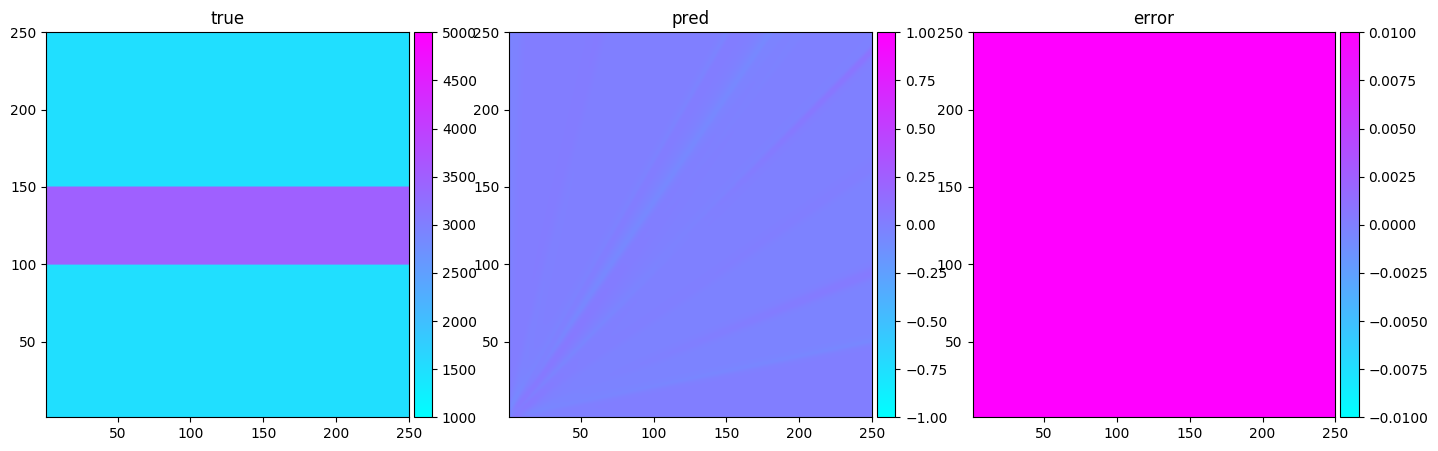

In [10]:
x_test = np.linspace(1.0, 250.0, 250)
z_test = np.linspace(1.0, 250.0, 499)
xz_test = tensor_grid([x_test, z_test])

c_pred = inverse_model(tf.constant(xz_test, dtype = tf.float32))
def c_func(x, z):
	return np.piecewise(z, [z > 150, (z >= 100) & (z <= 150), z < 100], [1500, 3500, 1500])
c_true = c_func(xz_test[:, 0:1], xz_test[:, 1:2])

import matplotlib as mpl
from matplotlib.cm import cool
from matplotlib.colors import Normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap = cool
norm = Normalize(vmin=1000, vmax=5000)

X, Z = np.meshgrid(x_test, z_test)
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.subplots_adjust(right = 1.0)

im0 = ax[0].contourf(X, Z, c_true.reshape((len(x_test), len(z_test))).T, cmap = cmap, norm = norm, levels = 100)
ax[0].set_title("true")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1, vmax=1)
im1 = ax[1].contourf(X, Z, c_pred.numpy().reshape((len(x_test), len(z_test))).T, cmap = cmap, norm = norm, levels = 100)
ax[1].set_title("pred")
ax[1].set_xlabel("")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1e-2, vmax=1e-2)
im2 = ax[2].contourf(X, Z, c_true.reshape((len(x_test), len(z_test))).T-c_pred.numpy().reshape((len(x_test), len(z_test))).T, cmap = cmap, norm = norm, levels = 100)
ax[2].set_title("error")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

plt.show()

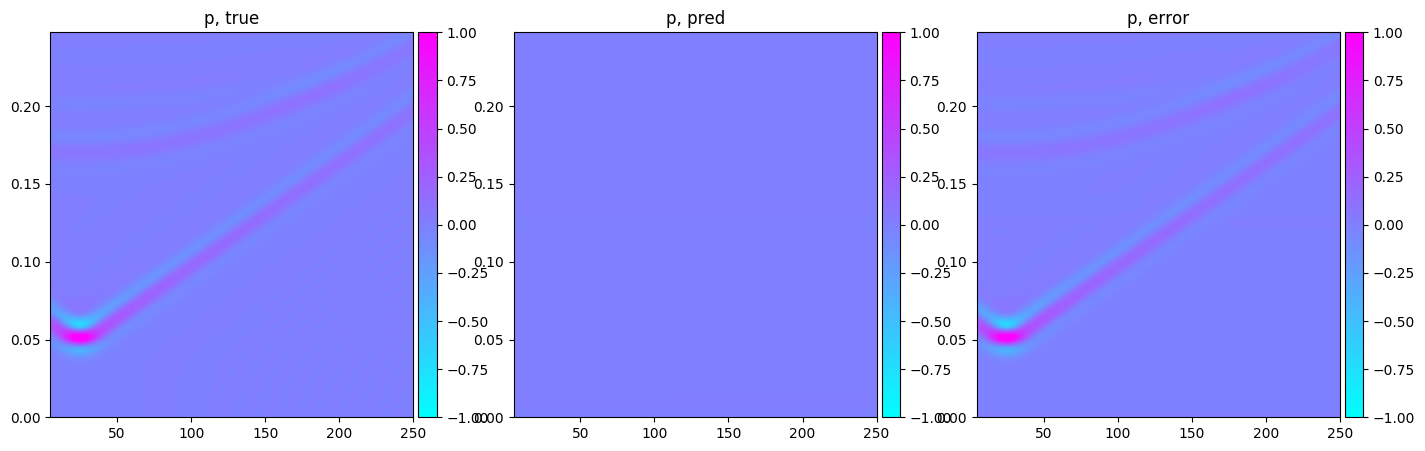

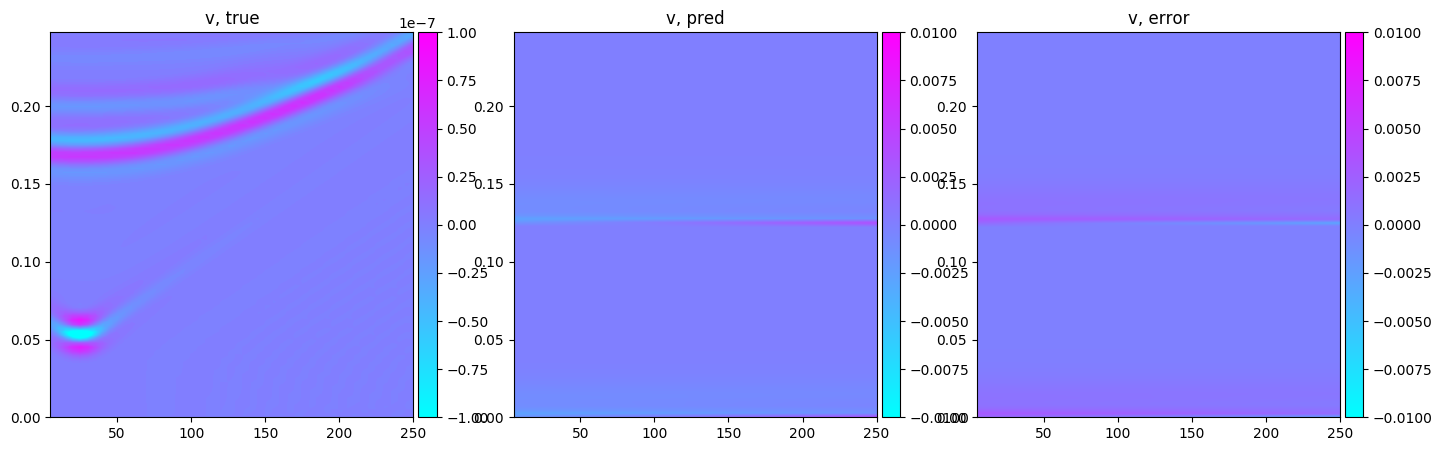

In [17]:
i = 0
p = loadmat("data/sr_p_{}.mat".format(int(x_s[i]/5)))["sr"]*1000
v = loadmat("data/sr_vz_{}.mat".format(int(x_s[i]/5)))["sr"]*1000

x_test = np.linspace(5.0, 250.0, 50)
# z_test = np.linspace(1.0, 250.0, 250)
z_test = [0]
t_test = np.linspace(0.0, 0.2475, 100)
xzt_test = tensor_grid([t_test, x_test, z_test])
xzt_test[:, [0, 1, 2]] = xzt_test[:, [1, 2, 0]]
out = direct_models[i](tf.constant(xzt_test, dtype = tf.float32))

cmap = cool
norm = Normalize(vmin=-1, vmax=1)

X, T = np.meshgrid(x_test, t_test)
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.subplots_adjust(right = 1.0)

im0 = ax[0].contourf(X, T, p, cmap = cmap, norm = norm, levels = 100)
ax[0].set_title("p, true")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = Normalize(vmin=-1, vmax=1)
im1 = ax[1].contourf(X, T, out[:, 0:1].numpy().reshape((len(x_test), len(t_test))).T, cmap = cmap, norm = norm, levels = 100)
ax[1].set_title("p, pred")
ax[1].set_xlabel("")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1, vmax=1)
im2 = ax[2].contourf(X, T, p-out[:, 0:1].numpy().reshape((len(x_test), len(t_test))).T, cmap = cmap, norm = norm, levels = 100)
ax[2].set_title("p, error")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')


fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.subplots_adjust(right = 1.0)

norm = Normalize(vmin=-1e-7, vmax=1e-7)
im0 = ax[0].contourf(X, T, v, cmap = cmap, norm = norm, levels = 100)
ax[0].set_title("v, true")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = Normalize(vmin=-1e-2, vmax=1e-2)
im1 = ax[1].contourf(X, T, out[:, 2:3].numpy().reshape((len(x_test), len(t_test))).T, cmap = cmap, norm = norm, levels = 100)
ax[1].set_title("v, pred")
ax[1].set_xlabel("")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1e-2, vmax=1e-2)
im2 = ax[2].contourf(X, T, v-out[:, 2:3].numpy().reshape((len(x_test), len(t_test))).T, cmap = cmap, norm = norm, levels = 100)
ax[2].set_title("v, error")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')
plt.show()

In [ ]:
X.shape

In [ ]:
p.shape